In [4]:
#This script implements a joint model
import pandas as pd 
import numpy as np 
import json
import os
from keras import layers
from keras import regularizers
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential 
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, Flatten
from keras.callbacks import EarlyStopping
from sklearn import metrics 
from keras_contrib.layers import CRF
import keras

def read_sent(sent):
	sent = sent.strip().split()
	start = int(sent[0])
	end = int(sent[1])
	sent = sent[4:]
	labels = [0]*len(sent)
	labels[start : end+1] = [1]*(end+1-start)
	return [(sent[i], str(labels[i])) for i in range(len(sent))]

def get_sents(data_dir):
	data = open(data_dir, 'r')
	data_list = data.readlines()

	sentences = [read_sent(sent) for sent in data_list]
	labels = [int(sent.strip().split()[2]) for sent in data_list]
	data.close()
	return sentences, labels

train_sents, train_dataset_id = get_sents("../../data/train.txt")
val_sents, val_dataset_id = get_sents("../../data/validate.txt")
test_sents, test_dataset_id = get_sents("../../data/test.txt")


def sent2labels(sent):
	return [int(label) for token, label in sent]

def sent2tokens(sent):
	return [token for token, label in sent]

data_set = pd.read_json('../../../train_test/data_sets.json', encoding='utf-8')
#note: dataset_id = index + 1
data_description = data_set["description"].values


maxlen = 100
emb_dim = 50
HIDDEN_DIM = 256
EPOCHS = 10  ## train more epochs with GPU, it takes 1h per epoch on my CPU
NEG_RATIO = 3
BATCH_SIZE = 10
DATASET_CLASS = len(data_description) 
MODEL_NAME = "LSTM"


# Add a sentence for no mention case
data_description = list(data_description)
data_description.insert(0, "There is no mention.")

X_train = [sent2tokens(s) for s in train_sents]
Y_train = [sent2labels(s) for s in train_sents]
X_val = [sent2tokens(s) for s in val_sents]
Y_val = [sent2labels(s) for s in val_sents]
X_test = [sent2tokens(s) for s in test_sents]
Y_test = [sent2labels(s) for s in test_sents]


##load glove
embedding_index = {}
f = open('../glove.6B.50d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embedding_index[word] = coefs
f.close()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train+X_val+X_test)
word_index = tokenizer.word_index

##hyperparameters
vocab_size = len(word_index)+1


embedding_matrix = np.zeros((vocab_size, emb_dim))
counter = 0
for word, i in word_index.items():
	embedding_vector = embedding_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
		counter += 1
	else:
		embedding_matrix[i] = np.random.randn(emb_dim)
print ("{}/{} words covered in glove".format(counter, vocab_size))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)


X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

Y_train = np.asarray(Y_train)
Y_val = np.asarray(Y_val)
Y_test_arr = np.asarray(Y_test)
Y_test = np.asarray(Y_test)

N = X_train.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)
X_train = X_train[indices]
Y_train = Y_train[indices] 

##labels for mention detection
#labels need to be 3D
Y_train = np.expand_dims(Y_train, axis=2)
Y_val = np.expand_dims(Y_val, axis=2)
Y_test = np.expand_dims(Y_test, axis=2)

Y_train = keras.utils.to_categorical(Y_train)
Y_val = keras.utils.to_categorical(Y_val)
Y_test = keras.utils.to_categorical(Y_test)


##labels for dataset
Y2_train = np.asarray(train_dataset_id)
Y2_val = np.asarray(val_dataset_id)
Y2_test = np.asarray(test_dataset_id)
Y2_train = keras.utils.to_categorical(Y2_train, num_classes=DATASET_CLASS)
Y2_val = keras.utils.to_categorical(Y2_val, num_classes=DATASET_CLASS)
Y2_test = keras.utils.to_categorical(Y2_test, num_classes=DATASET_CLASS)

##build model
input = Input(shape=(maxlen,))
emb = Embedding(vocab_size, emb_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input)

[lstm_seq, state_h_fw, state_h_bw, state_c_fw, state_c_bw] = Bidirectional(LSTM(100, return_sequences=True, return_state=True, recurrent_dropout=0.2))(emb)
##lstm_seq: (None, maxlen, 2*hidden_dim)
label_attn = TimeDistributed(Dense(200, activation='relu'))(lstm_seq)
##element wise multiply by attention
weighted_vec = layers.Multiply()([label_attn, lstm_seq])
##use CRF instead of Dense
crf = CRF(2)
mention = crf(label_attn)

dataset = Bidirectional(LSTM(100, recurrent_dropout=0.2))(weighted_vec)
data_id = Dense(DATASET_CLASS, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(dataset)

model = Model(input, [mention, data_id])

model.compile(optimizer='adam', loss=[crf.loss_function, 'categorical_crossentropy'], metrics=['accuracy']) 
history = model.fit(X_train, [Y_train, Y2_train], batch_size=64, epochs=3, 
                   validation_data=(X_test, [Y_test, Y2_test]))




/Users/sichenglei/Desktop/kaggle/salt/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


31257/50937 words covered in glove
Train on 30208 samples, validate on 3356 samples
Epoch 1/3
30208/30208 [==============================] - 615s 20ms/step - loss: 8.7514 - crf_1_loss: 0.0842 - dense_2_loss: 8.3641 - crf_1_acc: 0.9639 - dense_2_acc: 0.0842 - val_loss: 8.4959 - val_crf_1_loss: 0.0605 - val_dense_2_loss: 8.1624 - val_crf_1_acc: 0.9740 - val_dense_2_acc: 0.0855
Epoch 2/3
30208/30208 [==============================] - 565s 19ms/step - loss: 8.3461 - crf_1_loss: 0.0541 - dense_2_loss: 8.0163 - crf_1_acc: 0.9639 - dense_2_acc: 0.0846 - val_loss: 8.1918 - val_crf_1_loss: 0.0472 - val_dense_2_loss: 7.8726 - val_crf_1_acc: 0.9768 - val_dense_2_acc: 0.0855
Epoch 3/3
30208/30208 [==============================] - 437s 14ms/step - loss: 8.0480 - crf_1_loss: 0.0433 - dense_2_loss: 7.7407 - crf_1_acc: 0.9639 - dense_2_acc: 0.0838 - val_loss: 7.9002 - val_crf_1_loss: 0.0383 - val_dense_2_loss: 7.6086 - val_crf_1_acc: 0.9785 - val_dense_2_acc: 0.0855


In [5]:
[preds, data_id] = model.predict(X_test)
test = [[np.argmax(y) for y in x] for x in preds]
test_arr = np.asarray(test)
test = np.reshape(test_arr, (-1))

print (metrics.precision_recall_fscore_support(np.reshape(Y_test_arr,(-1)), test, average=None,
                                              labels=[0, 1]))



(array([0.98706764, 0.72089996]), array([0.9907244 , 0.64859891]), array([0.98889264, 0.68284091]), array([323645,  11955]))


First joint model:
dataset classififcation: 8.55%
mention discovery: F1 on 1s: 0.689, F1 on 0s: 0.989 

In [6]:
model.save("attn_1.h5")

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 50)      2546850     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 100, 200), ( 120800      embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 100, 200)     40200       bidirectional_1[0][0]            
__________________________________________________________________________________________________
multiply_1

In [7]:
def sent2tokens_idx(sent):
	return [token+"("+str(idx)+")" for idx, (token, label)  in enumerate(sent)]
X_test_sents = [sent2tokens_idx(s) for s in test_sents]

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import font_manager
import matplotlib
import keras.backend as K
%matplotlib inline

In [19]:
def get_activations(model, inputs, idx, print_shape_only=True, layer_name='attention_vec'):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
#     print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
#         if print_shape_only:
#             print(layer_activations.shape)
#         else:
#             print(layer_activations)
    act = np.mean(activations[0], axis=2).squeeze()
    plt.figure(figsize=(10,80))
    pd.DataFrame(act, columns=['attention (%)']).plot(kind='bar',
                                                      title='Attention Mechanism as '
                                                           'a function of input'
                                                           ' dimensions.', 
                                                      figsize=(20,5))
    plt.show()
    print (' '.join(X_test_sents[idx]))
#     return activations

<Figure size 720x5760 with 0 Axes>

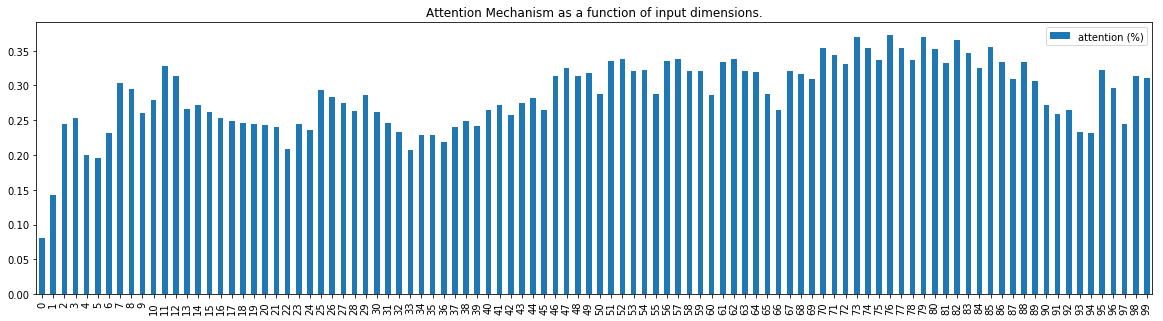

080(0) )(1) 0(2) .(3) 097(4) ***(5) ((6) 0(7) .(8) 013(9) )(10) Time(11) Fixed(12) Effects(13) Yes(14) Yes(15) Yes(16) Yes(17) Yes(18) Yes(19) Yes(20) Yes(21) Sector(22) Fixed(23) Effects(24) No(25) Yes(26) Yes(27) Yes(28) No(29) Yes(30) Yes(31) Yes(32) Observations(33) 326(34) ,(35) 957(36) 326(37) ,(38) 957(39) 326(40) ,(41) 957(42) 326(43) ,(44) 957(45) 8(46) ,(47) 312(48) ,(49) 832(50) 8(51) ,(52) 312(53) ,(54) 832(55) 8(56) ,(57) 312(58) ,(59) 832(60) 8(61) ,(62) 312(63) ,(64) 832(65) Firms(66) 43(67) ,(68) 296(69) 43(70) ,(71) 296(72) 43(73) ,(74) 296(75) 43(76) ,(77) 296(78) 43(79) ,(80) 296(81) 43(82) ,(83) 296(84) 43(85) ,(86) 296(87) 43(88) ,(89) 296(90) Adj(91) .(92) R(93) ˛(94) 0(95) .(96) 032(97) 0(98) .(99)


<Figure size 720x5760 with 0 Axes>

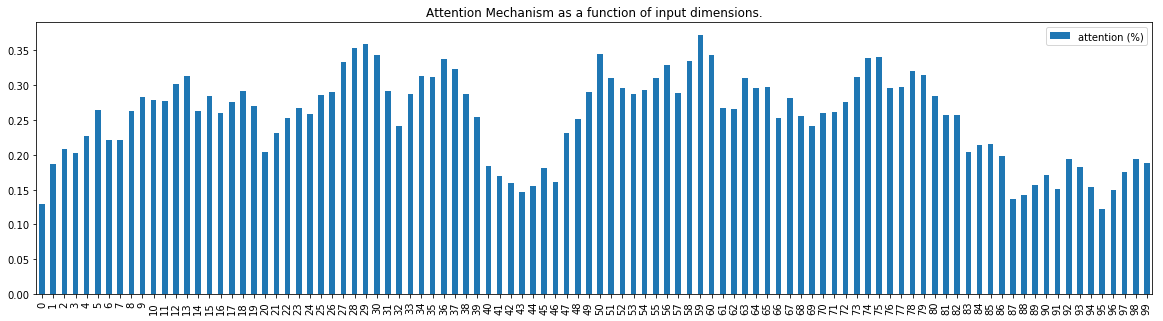

population(0) of(1) South(2) China(3) .(4) J(5) Clin(6) Epidemiol(7) 47(8) :(9) 173(10) ­(11) 181(12) ,(13) 1994(14) Frequency(15) and(16) Patients(17) '(18) Reported(19) Awareness(20) of(21) Diabetic(22) Retinopathy(23) Among(24) Type(25) 2(26) Diabetic(27) Patients(28) Admitted(29) to(30) Internal(31) Medicine(32) Wards(33) Although(34) diabetes(35) is(36) one(37) of(38) the(39) major(40) causes(41) of(42) blindness(43) ,(44) diabetic(45) retinopa(46) -(47) thy(48) can(49) be(50) prevented(51) in(52) most(53) cases(54) ((55) 1(56) ­(57) 8(58) ).(59) While(60) successful(61) treatment(62) is(63) depen(64) -(65) dent(66) on(67) early(68) intervention(69) ,(70) irreversible(71) damage(72) has(73) often(74) already(75) occurred(76) before(77) symptoms(78) appear(79) .(80) According(81) to(82) guidelines(83) issued(84) by(85) the(86) American(87) Diabetes(88) Associa(89) -(90) tion(91) and(92) the(93) American(94) Academy(95) of(96) Oph(97) -(98) thalmology(99)


<Figure size 720x5760 with 0 Axes>

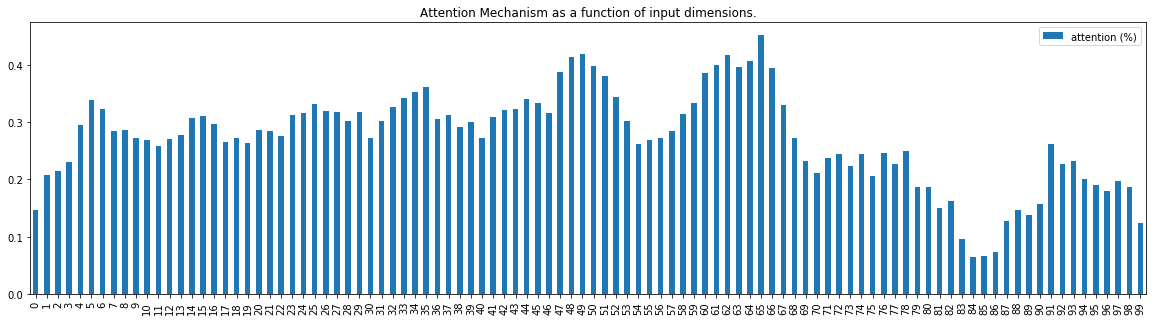

A(0) ((1) H3N2(2) )(3) virus(4) nor(5) the(6) combined(7) number(8) of(9) influenza(10) 832(11) Simonsen(12) et(13) al(14) .(15) JID(16) 2000(17) ;(18) 181(19) ((20) March(21) )(22) Figure(23) 1(24) .(25) US(26) pneumonia(27) and(28) influenza(29) monthly(30) hospitalizations(31) ,(32) all(33) ages(34) ,(35) 1970(36) ­(37) 1995(38) .(39) Laboratory(40) -(41) confirmed(42) influenza(43) periods(44) and(45) baseline(46) levels(47) are(48) indicated(49) for(50) each(51) season(52) .(53) A(54) ((55) H1N1(56) )(57) and(58) influenza(59) B(60) viruses(61) accounted(62) for(63) 75(64) %(65) of(66) the(67) sea(68) -(69) son(70) '(71) s(72) isolates(73) .(74) Data(75) source(76) for(77) P(78) &(79) I(80) hospitalizations(81) .(82) National(83) Hospitalization(84) Discharge(85) Survey(86) ((87) NHDS(88) )(89) data(90) were(91) obtained(92) for(93) 1970(94) ­(95) 1995(96) from(97) the(98) National(99)


<Figure size 720x5760 with 0 Axes>

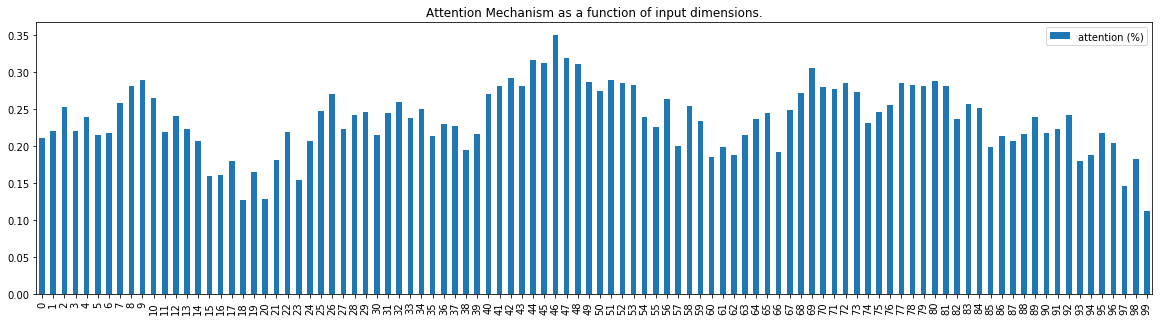

one(0) state(1) has(2) suc(3) -(4) cessfully(5) included(6) pregnant(7) women(8) in(9) the(10) statutes(11) that(12) call(13) for(14) involuntary(15) commitment(16) .(17) Tort(18) actions(19) Tort(20) actions(21) are(22) civil(23) actions(24) that(25) are(26) filed(27) by(28) an(29) independ(30) -(31) ent(32) party(33) on(34) behalf(35) of(36) the(37) fetus(38) [(39) 147(40) ,(41) 149(42) ].(43) These(44) actions(45) are(46) meant(47) to(48) deter(49) drug(50) use(51) by(52) imposing(53) financial(54) conse(55) -(56) quences(57) on(58) the(59) drug(60) -(61) using(62) mother(63) .(64) In(65) tort(66) actions(67) women(68) are(69) held(70) accountable(71) for(72) the(73) financial(74) burden(75) incurred(76) for(77) the(78) cost(79) of(80) the(81) birth(82) of(83) the(84) drug(85) -(86) exposed(87) baby(88) .(89) State(90) statutes(91) In(92) formulating(93) laws(94) ,(95) whether(96) criminal(97) or(98) civil(99)


<Figure size 720x5760 with 0 Axes>

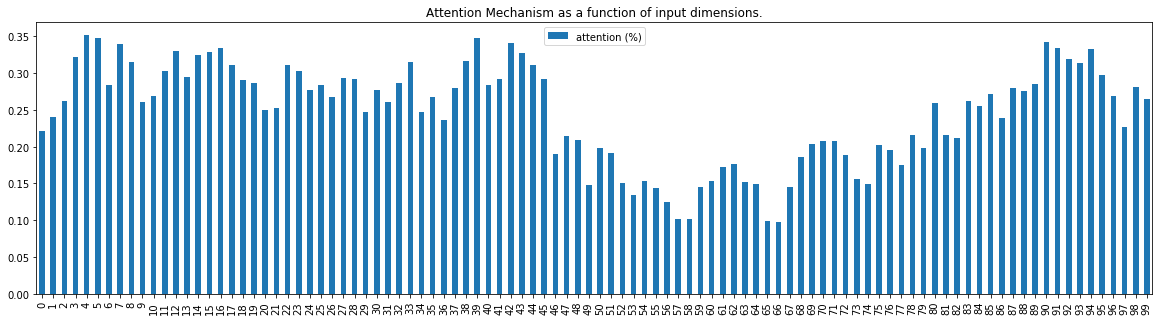

1(0) ­(1) 407(2) .(3) 12(4) .(5) Forghani(6) B(7) ,(8) Schmidt(9) NJ(10) .(11) Antigen(12) requirements(13) ,(14) sensitivity(15) ,(16) and(17) spec(18) -(19) ificity(20) of(21) enzyme(22) immunoassays(23) for(24) measles(25) and(26) rubella(27) viral(28) antibod(29) -(30) ies(31) .(32) J(33) Clin(34) Microbiol(35) 1979(36) ;(37) 9(38) :(39) 657(40) ­(41) 64(42) .(43) 13(44) .(45) Ezzati(46) T(47) ,(48) Khare(49) M(50) .(51) Nonresponse(52) adjustment(53) in(54) a(55) national(56) health(57) survey(58) .(59) In(60) :(61) Proceedings(62) of(63) the(64) Survey(65) Research(66) Methods(67) Section(68) of(69) the(70) Amer(71) -(72) ican(73) Statistical(74) Association(75) .(76) Alexandria(77) ,(78) VA(79) :(80) American(81) Statistical(82) As(83) -(84) sociation(85) 1993(86) ;(87) 339(88) ­(89) 44(90) .(91) 14(92) .(93) Mohadjer(94) L(95) ,(96) Montaquila(97) J(98) ,(99)


<Figure size 720x5760 with 0 Axes>

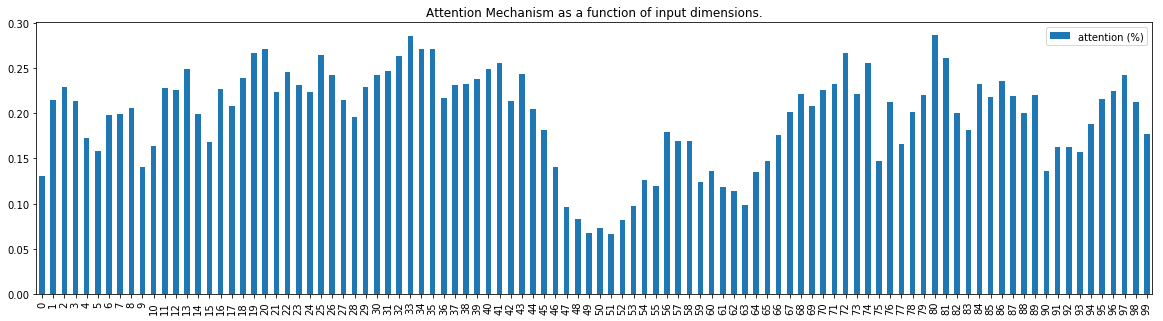

Letters(0) to(1) the(2) Editor(3) Data(4) advisory(5) with(6) regard(7) to(8) NHANES(9) serum(10) 25(11) -(12) hydroxyvitamin(13) D(14) data(15) Dear(16) Sir(17) :(18) We(19) are(20) writing(21) to(22) alert(23) readers(24) that(25) a(26) data(27) advisory(28) with(29) regard(30) to(31) serum(32) 25(33) -(34) hydroxyvitamin(35) D(36) [(37) 25(38) ((39) OH(40) )(41) D(42) ](43) data(44) from(45) the(46) National(47) Health(48) and(49) Nutrition(50) Examination(51) Survey(52) ((53) NHANES(54) )(55) has(56) recently(57) been(58) posted(59) on(60) the(61) NHANES(62) website(63) ((64) http(65) ://(66) www(67) .(68) cdc(69) .(70) gov(71) /(72) nchs(73) /(74) nhanes(75) /(76) new_nhanes(77) .(78) htm(79) ).(80) This(81) advisory(82) outlines(83) 2(84) issues(85) that(86) all(87) users(88) of(89) NHANES(90) serum(91) 25OHD(92) data(93) need(94) to(95) consider(96) .(97) The(98) purpose(99)


<Figure size 720x5760 with 0 Axes>

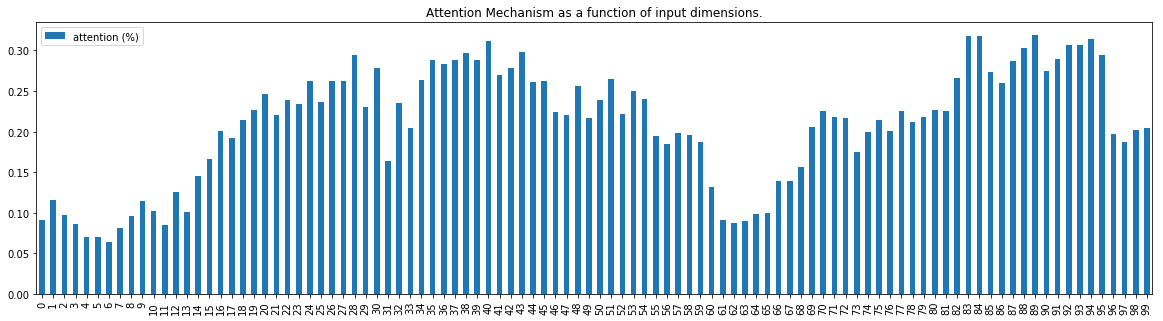

Prevention(0) .(1) National(2) Health(3) and(4) Nutrition(5) Examination(6) Survey(7) ((8) NHANES(9) )(10) Questionnaire(11) and(12) Exam(13) Protocol(14) .(15) <(16) http(17) ://(18) www(19) .(20) cdc(21) .(22) gov(23) /(24) nchs(25) /(26) about(27) /(28) major(29) /(30) nhanes(31) /(32) questexam(33) .(34) htm(35) >.(36) 17(37) .(38) OstchegaY(39) ,(40) Prineas(41) RJ(42) ,(43) Paulose(44) -(45) Ram(46) R(47) ,(48) Grim(49) CM(50) ,(51) Willard(52) G(53) ,(54) Collins(55) D(56) .(57) J(58) .(59) National(60) Health(61) and(62) Nutrition(63) Examination(64) Survey(65) 1999(66) ­(67) 2000(68) :(69) effect(70) of(71) observer(72) training(73) and(74) protocol(75) standardization(76) on(77) reducing(78) blood(79) pressure(80) measurement(81) error(82) .(83) J(84) ClinEpidemiol(85) 2003(86) ;(87) 56(88) :(89) 768(90) ­(91) 774(92) .(93) 18(94) .(95) National(96) High(97) Blood(98) Pressure(99)


<Figure size 720x5760 with 0 Axes>

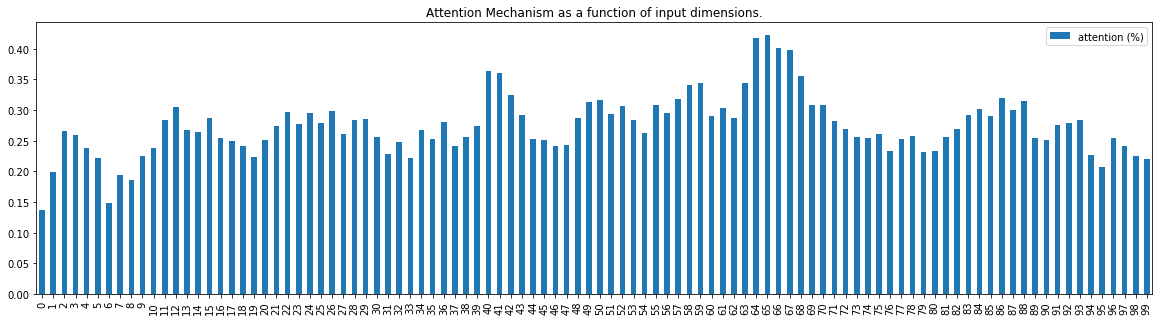

organism(0) ;(1) thus(2) ,(3) vigilance(4) in(5) promoting(6) appropriate(7) microbial(8) transmission(9) protocols(10) should(11) remain(12) a(13) priority(14) .(15) Ann(16) Fam(17) Med(18) 2006(19) ;(20) 4(21) :(22) 132(23) -(24) 137(25) .(26) DOI(27) :(28) 10(29) .(30) 1370(31) /(32) afm(33) .(34) 526(35) .(36) INTRODUCTION(37) Staphylococcus(38) aureus(39) is(40) one(41) of(42) the(43) most(44) common(45) human(46) pathogens(47) and(48) is(49) capable(50) of(51) causing(52) a(53) wide(54) range(55) of(56) infections(57) .(58) Although(59) primary(60) S(61) aureus(62) infections(63) are(64) not(65) common(66) ,(67) a(68) great(69) deal(70) of(71) the(72) virulence(73) from(74) this(75) organism(76) occurs(77) through(78) cross(79) -(80) infection(81) by(82) spread(83) from(84) patient(85) to(86) pa(87) -(88) tient(89) in(90) hospitals(91) and(92) other(93) institutional(94) settings(95) .(96) In(97) contrast(98) ,(99)


<Figure size 720x5760 with 0 Axes>

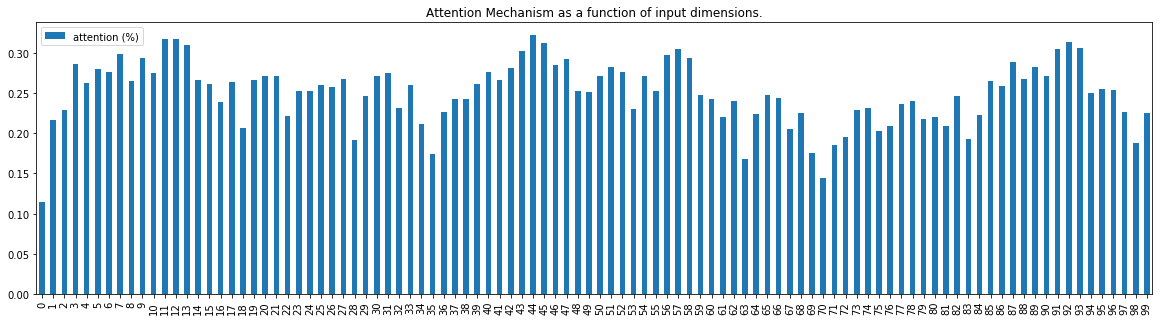

Adol(0) .(1) Med(2) .(3) 2007(4) ,(5) 161(6) ,(7) 959(8) -(9) 966(10) .(11) 81(12) .(13) Hanewinkel(14) ,(15) R(16) .;(17) Morgenstern(18) ,(19) M(20) .;(21) Tanski(22) ,(23) S(24) .(25) E(26) .;(27) Sargent(28) ,(29) J(30) .(31) D(32) .(33) Longitudinal(34) study(35) of(36) parental(37) movie(38) restriction(39) on(40) teen(41) smoking(42) and(43) drinking(44) in(45) Germany(46) .(47) Addiction(48) 2008(49) ,(50) 103(51) ,(52) 1722(53) -(54) 1730(55) .(56) 82(57) .(58) Hanewinkel(59) ,(60) R(61) .;(62) Sargent(63) ,(64) J(65) .(66) D(67) .(68) Longitudinal(69) study(70) of(71) exposure(72) to(73) entertainment(74) media(75) and(76) alcohol(77) use(78) among(79) German(80) adolescents(81) .(82) Pediatrics(83) 2009(84) ,(85) 123(86) ,(87) 989(88) -(89) 995(90) .(91) 83(92) .(93) Henriksen(94) ,(95) L(96) .;(97) Feighery(98) ,(99)


<Figure size 720x5760 with 0 Axes>

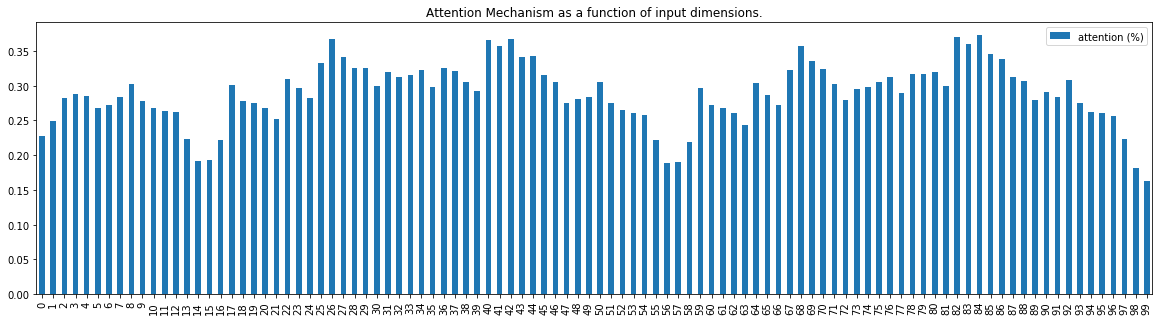

07(0) ,(1) 3(2) .(3) 72(4) )(5) Gidwani(6) et(7) al(8) .(9) [(10) 110(11) ](12) Onset(13) of(14) smoking(15) ((16) any(17) last(18) 3(19) months(20) )(21) TV(22) -(23) viewing(24) hours(25) per(26) day(27) :(28) low(29) ((30) 2(31) -(32) 3(33) hours(34) )(35) 2(36) .(37) 00(38) ((39) 0(40) .(41) 37(42) ,(43) 10(44) .(45) 63(46) )(47) Gidwani(48) et(49) al(50) .(51) [(52) 110(53) ](54) Onset(55) of(56) smoking(57) ((58) any(59) last(60) 3(61) months(62) )(63) TV(64) -(65) viewing(66) hours(67) per(68) day(69) :(70) moderate(71) ((72) 3(73) -(74) 4(75) hours(76) )(77) 3(78) .(79) 15(80) ((81) 0(82) .(83) 64(84) ,(85) 15(86) .(87) 40(88) )(89) Gidwani(90) et(91) al(92) .(93) [(94) 110(95) ](96) Onset(97) of(98) smoking(99)


<Figure size 720x5760 with 0 Axes>

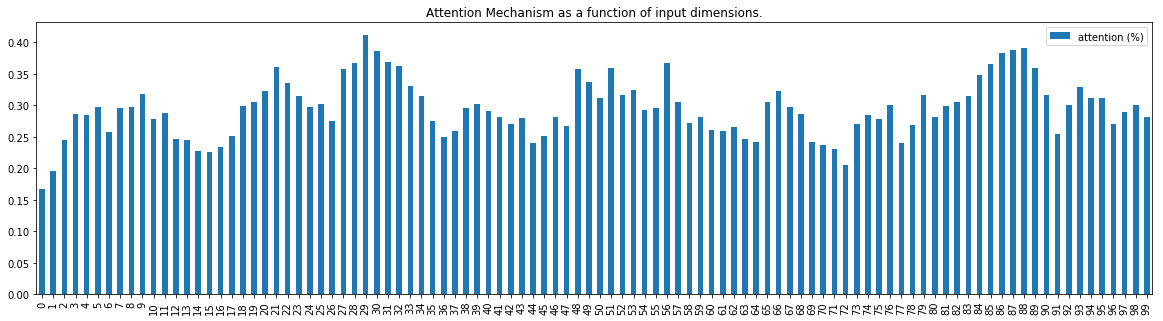

of(0) cognitive(1) decline(2) .(3) Together(4) ,(5) neigh(6) -(7) borhood(8) percent(9) Mexican(10) -(11) American(12) and(13) neighborhood(14) economic(15) advantage(16) explained(17) 10(18) .(19) 5(20) %(21) of(22) the(23) between(24) -(25) neighborhood(26) variance(27) in(28) rate(29) of(30) decline(31) .(32) Figure(33) 1(34) displays(35) cognitive(36) growth(37) curves(38) over(39) time(40) by(41) quartile(42) of(43) economic(44) advantage(45) .(46) Explanatory(47) variables(48) and(49) covariates(50) not(51) included(52) in(53) the(54) graph(55) were(56) held(57) constant(58) at(59) the(60) mean(61) .(62) Multilevel(63) logistic(64) regression(65) models(66) predicting(67) the(68) odds(69) of(70) decline(71) (!(72) 3(73) points(74) )(75) at(76) wave(77) 3(78) are(79) presented(80) in(81) Table(82) 4(83) .(84) Having(85) less(86) than(87) 5(88) years(89) of(90) education(91) ,(92) being(93) older(94) at(95) baseline(96) ,(97) having(98) more(99)


<Figure size 720x5760 with 0 Axes>

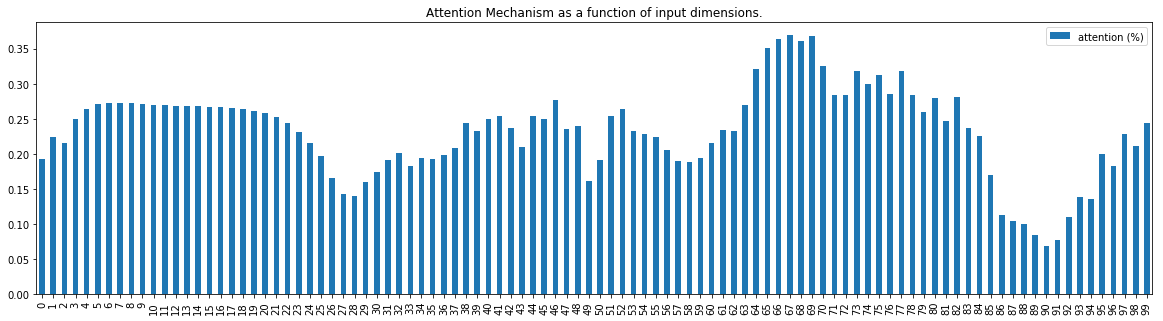

7(0) September(1) 2006(2) .(3) .(4) .(5) .(6) .(7) .(8) .(9) .(10) .(11) .(12) .(13) .(14) .(15) .(16) .(17) .(18) .(19) .(20) .(21) .(22) .(23) .(24) .(25) Injury(26) Prevention(27) 2006(28) ;(29) 12(30) ((31) Suppl(32) II(33) ):(34) ii39(35) ­(36) ii43(37) .(38) doi(39) :(40) 10(41) .(42) 1136(43) /(44) ip(45) .(46) 2006(47) .(48) 012658(49) Introduction(50) :(51) To(52) better(53) understand(54) ,(55) and(56) ultimately(57) prevent(58) ,(59) infant(60) /(61) child(62) homicide(63) ,(64) it(65) is(66) imperative(67) to(68) more(69) thoroughly(70) elucidate(71) the(72) circumstances(73) and(74) conditions(75) related(76) to(77) such(78) instances(79) .(80) Data(81) were(82) obtained(83) from(84) the(85) US(86) National(87) Violent(88) Death(89) Reporting(90) System(91) ((92) NVDRS(93) )(94) to(95) illuminate(96) circumstances(97) related(98) to(99)


<Figure size 720x5760 with 0 Axes>

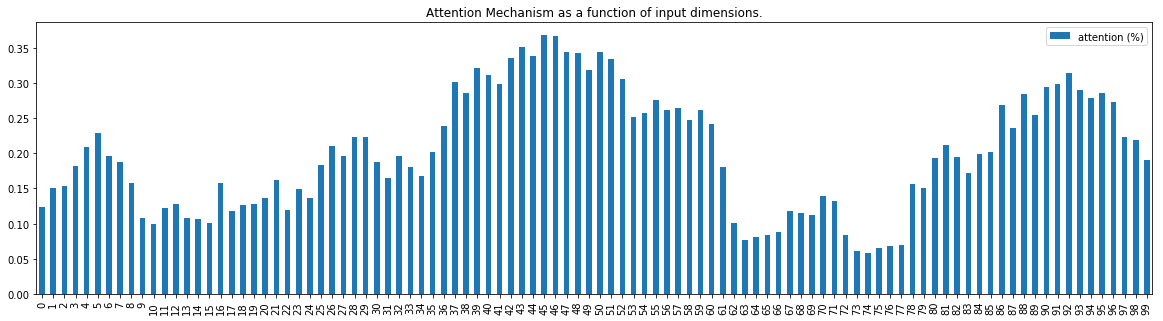

Emergency(0) and(1) outpatient(2) department(3) use(4) was(5) examined(6) after(7) the(8) State(9) Children(10) '(11) s(12) Health(13) Insurance(14) Program(15) ((16) CHIP(17) )(18) coverage(19) expansion(20) ,(21) focusing(22) on(23) adolescents(24) ((25) a(26) major(27) target(28) group(29) for(30) CHIP(31) )(32) versus(33) young(34) adults(35) ((36) not(37) targeted(38) ).(39) The(40) hypothesis(41) was(42) that(43) coverage(44) would(45) increase(46) use(47) of(48) outpatient(49) services(50) ,(51) and(52) ED(53) use(54) would(55) decrease(56) .(57) Methods(58) :(59) Using(60) the(61) National(62) Ambulatory(63) Medical(64) Care(65) Survey(66) ((67) NAMCS(68) )(69) and(70) the(71) National(72) Hospital(73) Ambulatory(74) Medical(75) Care(76) Survey(77) ((78) NHAMCS(79) ),(80) the(81) years(82) 1992(83) ­(84) 1996(85) were(86) analyzed(87) as(88) baseline(89) and(90) then(91) compared(92) to(93) use(94) patterns(95) in(96) 1999(97) ­(98) 2009(99)


<Figure size 720x5760 with 0 Axes>

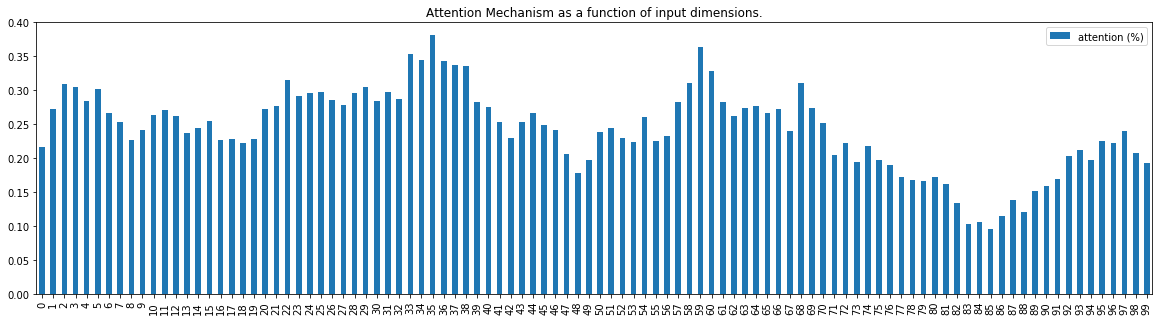

inducing(0) price(1) for(2) the(3) input(4) ,(5) pushing(6) the(7) entrepreneurs(8) with(9) small(10) capital(11) stock(12) out(13) of(14) the(15) market(16) .(17) Our(18) theoretical(19) model(20) suggests(21) that(22) in(23) areas(24) with(25) strong(26) networks(27) ,(28) an(29) honesty(30) inducing(31) input(32) price(33) is(34) low(35) ,(36) accommodating(37) small(38) entrepreneurs(39) in(40) the(41) system(42) .(43) But(44) as(45) formal(46) systems(47) improve(48) ((49) and(50) consequently(51) the(52) input(53) price(54) rises(55) ),(56) these(57) areas(58) are(59) the(60) worst(61) hit(62) as(63) facing(64) the(65) rising(66) input(67) prices(68) ,(69) the(70) entrepreneurs(71) are(72) forced(73) to(74) quit(75) the(76) market(77) .(78) We(79) use(80) the(81) India(82) Human(83) Development(84) Survey(85) ((86) IHDS(87) )(88) 2004(89) -(90) 2005(91) to(92) test(93) our(94) theoretical(95) predictions(96) .(97) In(98) accordance(99)


<Figure size 720x5760 with 0 Axes>

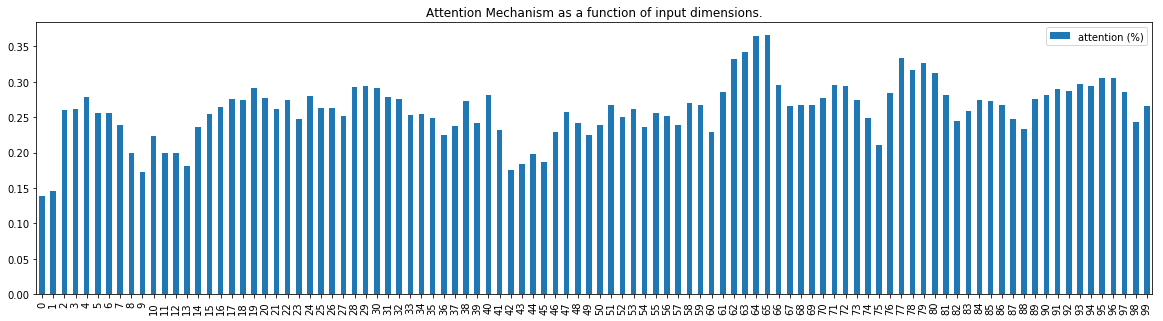

CIS(0) grants(1) are(2) associated(3) with(4) an(5) increase(6) in(7) SRO(8) employment(9) at(10) the(11) police(12) agency(13) level(14) ,(15) and(16) also(17) an(18) increase(19) in(20) the(21) presence(22) of(23) security(24) in(25) local(26) schools(27) ,(28) I(29) now(30) turn(31) to(32) the(33) reduced(34) form(35) impacts(36) of(37) these(38) grants(39) on(40) the(41) school(42) envi(43) -(44) ronment(45) .(46) If(47) SROs(48) promote(49) trust(50) between(51) officers(52) and(53) young(54) people(55) and(56) encourage(57) them(58) to(59) report(60) crimes(61) that(62) previously(63) would(64) have(65) gone(66) unreported(67) and(68) unpunished(69) ,(70) we(71) would(72) expect(73) CIS(74) grants(75) to(76) be(77) associated(78) with(79) more(80) officially(81) reported(82) crimes(83) in(84) and(85) out(86) of(87) school(88) ,(89) and(90) also(91) potentially(92) more(93) arrests(94) associated(95) with(96) those(97) crimes(98) .(99)


<Figure size 720x5760 with 0 Axes>

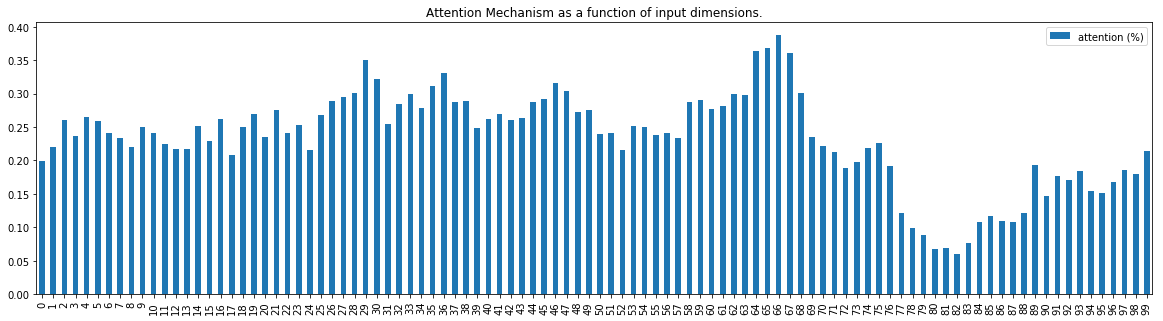

Prevalence(0) of(1) Pelvic(2) Paget(3) '(4) s(5) Disease(6) of(7) Bone(8) in(9) the(10) United(11) States(12) R(13) .(14) D(15) .(16) ALTMAN(17) ,(18) 1(19) D(20) .(21) A(22) .(23) BLOCH(24) ,(25) 2(26) M(27) .(28) C(29) .(30) HOCHBERG(31) ,(32) 3(33) and(34) W(35) .(36) A(37) .(38) MURPHY4(39) ABSTRACT(40) The(41) objective(42) of(43) this(44) article(45) was(46) to(47) estimate(48) the(49) prevalence(50) of(51) Paget(52) '(53) s(54) disease(55) of(56) bone(57) in(58) the(59) United(60) States(61) from(62) a(63) statistically(64) derived(65) sample(66) of(67) the(68) general(69) population(70) .(71) Pelvic(72) radiographs(73) obtained(74) in(75) the(76) First(77) National(78) Health(79) and(80) Nutrition(81) Examination(82) Survey(83) ((84) NHANES(85) -(86) I(87) )(88) were(89) reviewed(90) for(91) the(92) presence(93) of(94) Paget(95) '(96) s(97) disease(98) .(99)


<Figure size 720x5760 with 0 Axes>

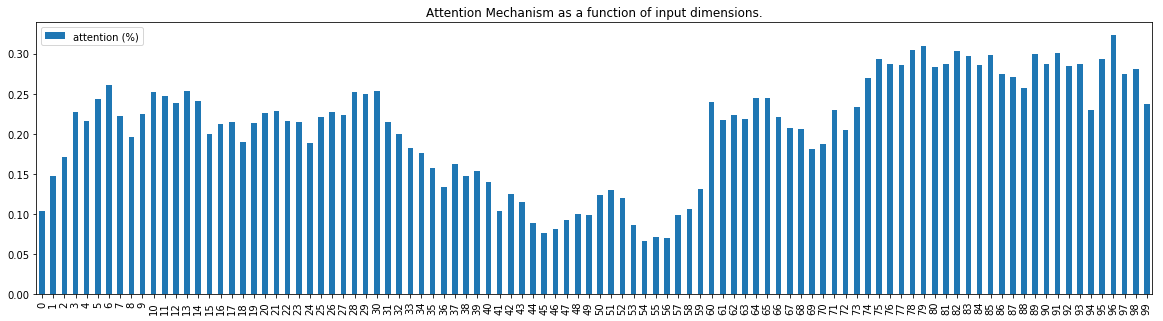

NHIS(0) Eileen(1) M(2) .(3) Crimmins(4) ,(5) 1(6) Yasuhiko(7) Saito(8) ,(9) 2(10) and(11) Sandra(12) L(13) .(14) Reynolds3(15) '(16) Andrus(17) Gerontology(18) Center(19) ,(20) University(21) of(22) Southern(23) California(24) .(25) 2Nihon(26) University(27) ,(28) Tokyo(29) ,(30) Japan(31) .(32) '(33) Department(34) of(35) Gerontology(36) ,(37) University(38) of(39) South(40) Florida(41) .(42) The(43) Longitudinal(44) Study(45) on(46) Aging(47) ((48) LSOA(49) )(50) and(51) the(52) National(53) Health(54) Interview(55) Survey(56) ((57) NHIS(58) )(59) are(60) used(61) to(62) examine(63) change(64) in(65) the(66) prevalence(67) of(68) disabilityfrom(69) 1982(70) through(71) 1993(72) for(73) persons(74) 70(75) years(76) of(77) age(78) and(79) over(80) .(81) Changes(82) in(83) the(84) likelihood(85) of(86) becoming(87) disabled(88) and(89) the(90) likelihood(91) of(92) recoveringfrom(93) disability(94) also(95) are(96) investigated(97) with(98) the(99)


<Figure size 720x5760 with 0 Axes>

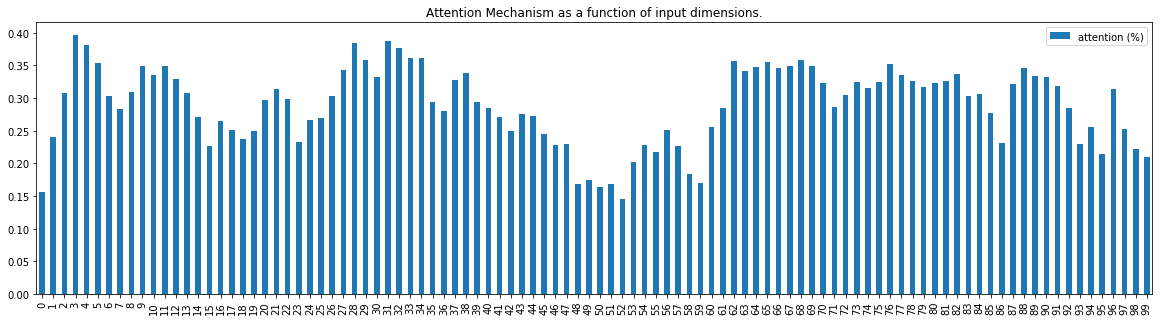

Patient(0) Definition(1) Patients(2) were(3) persons(4) whose(5) first(6) cancer(7) diagnosis(8) ,(9) at(10) least(11) 1(12) year(13) after(14) baseline(15) ,(16) was(17) esophageal(18) cancer(19) ((20) In(21) -(22) ternational(23) Classificationof(24) Diseases(25) code(26) 150(27) ).(28) Fifteen(29) subjects(30) were(31) diagnosed(32) w(33) :(34) ithesophageal(35) cancer(36) ,(37) all(38) of(39) whom(40) had(41) died(42) by(43) the(44) time(45) of(46) the(47) 1987(48) follow(49) -(50) up(51) study(52) .(53) Aspirin(54) Data(55) At(56) the(57) baseline(58) examination(59) ,(60) persons(61) were(62) asked(63) whether(64) they(65) had(66) taken(67) aspirin(68) in(69) the(70) past(71) 30(72) days(73) ,(74) and(75) if(76) so(77) ,(78) the(79) number(80) of(81) days(82) previous(83) to(84) the(85) examination(86) that(87) they(88) had(89) taken(90) it(91) .(92) Baseline(93) aspirin(94) data(95) were(96) avail(97) -(98) able(99)


<Figure size 720x5760 with 0 Axes>

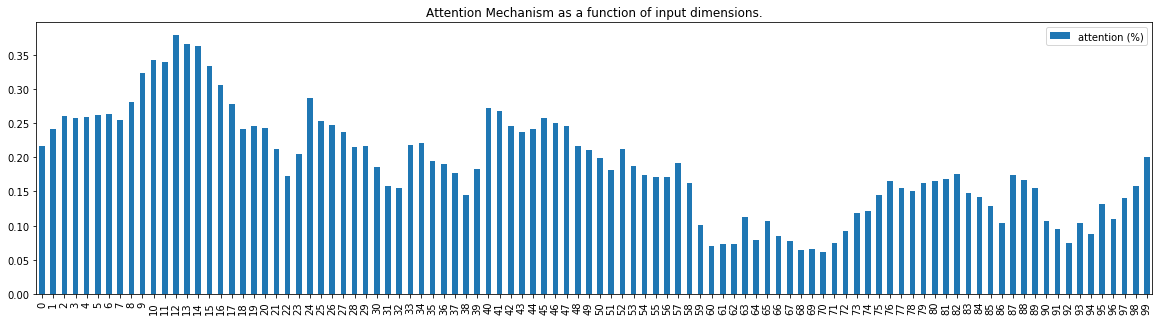

into(0) an(1) automated(2) data(3) collection(4) system(5) .(6) ANALYSES(7) ACCOMMODATING(8) SAMPLE(9) WEIGHTS(10) AND(11) SAMPLE(12) CLUSTERING(13) Many(14) of(15) the(16) statistical(17) issues(18) involved(19) in(20) analyzing(21) survey(22) data(23) are(24) the(25) same(26) as(27) encountered(28) when(29) analyzing(30) nonsurvey(31) data(32) .(33) The(34) two(35) characteristics(36) of(37) survey(38) data(39) that(40) most(41) complicate(42) Table(43) 1(44) .(45) Examples(46) of(47) cancer(48) -(49) related(50) analyses(51) with(52) the(53) use(54) of(55) data(56) from(57) the(58) National(59) Health(60) Interview(61) Surveys(62) ((63) NHIS(64) ),(65) National(66) Health(67) and(68) Nutrition(69) Examination(70) Surveys(71) ((72) NHANES(73) )(74) ((75) including(76) the(77) follow(78) -(79) up(80) of(81) the(82) 1971(83) ­(84) 1975(85) survey(86) ),(87) and(88) the(89) 1986(90) National(91) Mortality(92) Followback(93) Survey(94) Time(95) trends(96) of(97) Reference(98) No(99)


<Figure size 720x5760 with 0 Axes>

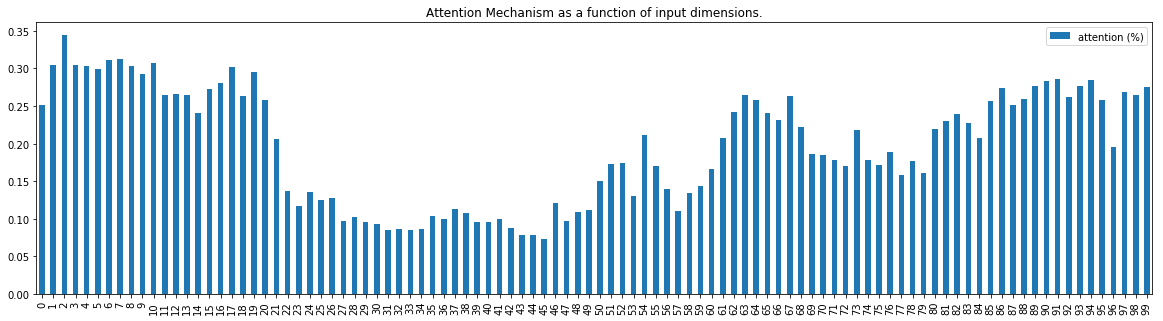

,(0) age(1) ,(2) race(3) ,(4) and(5) gender(6) as(7) covariates(8) in(9) all(10) cross(11) -(12) sectional(13) analyses(14) .(15) METHOD(16) Sample(17) Data(18) are(19) from(20) the(21) New(22) Haven(23) site(24) of(25) the(26) Established(27) Populations(28) for(29) the(30) Epidemiologic(31) Study(32) of(33) the(34) Elderly(35) ((36) EPESE(37) )(38) project(39) of(40) the(41) National(42) Institute(43) on(44) Aging(45) ((46) Cornoni(47) -(48) Huntley(49) et(50) al(51) .,(52) 1986(53) ).(54) Noninstitutionalized(55) ,(56) community(57) -(58) dwelling(59) elderly(60) persons(61) ((62) N(63) =(64) 2812(65) )(66) in(67) the(68) city(69) of(70) New(71) Haven(72) were(73) interviewed(74) annually(75) from(76) 1982(77) through(78) 1989(79) ,(80) and(81) again(82) in(83) 1994(84) ,(85) some(86) years(87) in(88) person(89) ,(90) some(91) by(92) telephone(93) .(94) The(95) stratified(96) probability(97) sample(98) was(99)


<Figure size 720x5760 with 0 Axes>

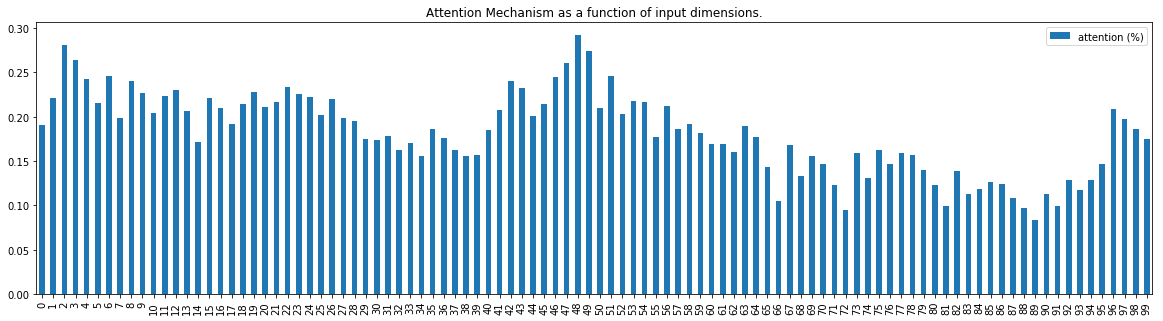

.(0) Designed(1) as(2) a(3) longitudinal(4) study(5) of(6) productivity(7) and(8) successful(9) aging(10) in(11) the(12) of(13) productivity(14) and(15) successful(16) aging(17) in(18) the(19) middle(20) and(21) later(22) years(23) of(24) life(25) ,(26) the(27) ACL(28) middle(29) and(30) later(31) years(32) of(33) life(34) ,(35) the(36) ACL(37) database(38) includes(39) measures(40) relevant(41) to(42) the(43) database(44) includes(45) measures(46) relevant(47) to(48) the(49) study(50) of(51) psychosocial(52) influences(53) on(54) study(55) of(56) psychosocial(57) influences(58) on(59) depression(60) .(61) depression(62) .(63) The(64) ACL(65) survey(66) was(67) conducted(68) in(69) The(70) ACL(71) survey(72) was(73) conducted(74) in(75) waves(76) ,(77) with(78) a(79) baseline(80) survey(81) in(82) 1986(83) waves(84) ,(85) with(86) a(87) baseline(88) survey(89) in(90) 1986(91) ((92) Wave(93) I(94) )(95) and(96) a(97) follow(98) -(99)


<Figure size 720x5760 with 0 Axes>

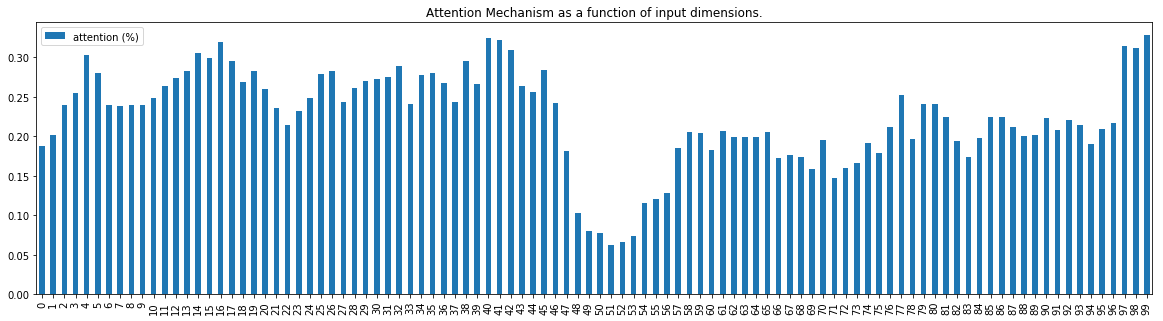

it(0) ti(1) io(2) on(3) n(4) S(5) Su(6) ur(7) rv(8) ve(9) ey(10) y(11) ((12) ((13) N(14) NH(15) HA(16) AN(17) NE(18) ES(19) S(20) I(21) I(22) )(23) )(24) J(25) .(26) Schwartz(27) *,(28) S(29) .(30) T(31) .(32) Weiss(33) **(34) The(35) relationship(36) of(37) dietary(38) fish(39) intake(40) to(41) level(42) of(43) pulmonary(44) function(45) in(46) the(47) first(48) National(49) Health(50) and(51) Nutrition(52) Survey(53) ((54) NHANES(55) I(56) ).(57) J(58) .(59) Schwartz(60) ,(61) S(62) .(63) T(64) .(65) Weiss(66) .(67) ERS(68) Journals(69) Ltd(70) 1994(71) .(72) ABSTRACT(73) :(74) Eicosapentaenoic(75) acid(76) ((77) EPA(78) ),(79) which(80) predominates(81) in(82) marine(83) fish(84) ,(85) tends(86) to(87) counteract(88) and(89) inhibit(90) the(91) uptake(92) and(93) incorporation(94) of(95) arachidonic(96) acid(97) and(98) membrane(99)


<Figure size 720x5760 with 0 Axes>

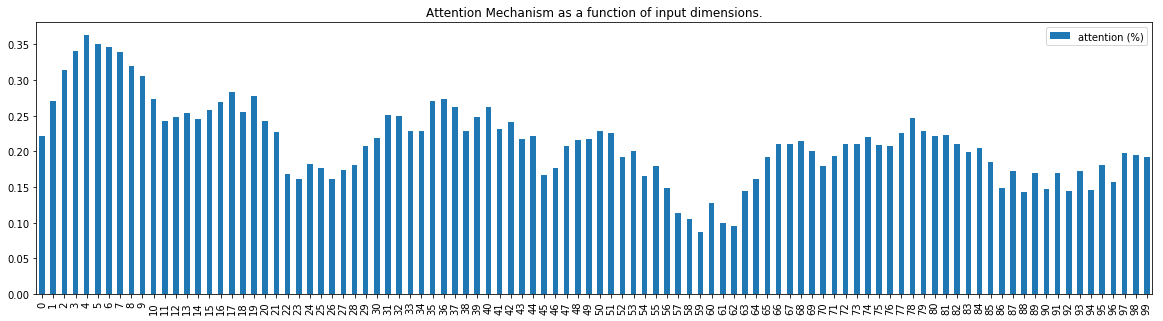

within(0) US(1) neighbourhoods(2) and(3) cities(4) .(5) Quantify(6) geographical(7) clustering(8) of(9) first(10) experience(11) with(12) cocaine(13) by(14) neighbourhood(15) context(16) .(17) Design(18) :(19) Estimate(20) the(21) PWOR(22) of(23) incident(24) cocaine(25) experience(26) at(27) two(28) levels(29) ((30) neighbourhood(31) ,(32) city(33) )(34) and(35) compare(36) across(37) years(38) .(39) Within(40) years(41) ,(42) estimate(43) the(44) PWOR(45) by(46) neighbourhood(47) disadvantage(48) and(49) test(50) for(51) trend(52) .(53) Setting(54) :(55) US(56) National(57) Household(58) Survey(59) on(60) Drug(61) Abuse(62) .(63) Participants(64) :(65) Civilian(66) ,(67) non(68) -(69) institutionalised(70) household(71) residents(72) of(73) the(74) United(75) States(76) age(77) 12(78) years(79) and(80) older(81) interviewed(82) in(83) person(84) during(85) 1979(86) ,(87) 1988(88) ,(89) 1990(90) ,(91) 1991(92) ,(93) 1992(94) ,(95) 1993(96) .(97) Main(98) results(99)


<Figure size 720x5760 with 0 Axes>

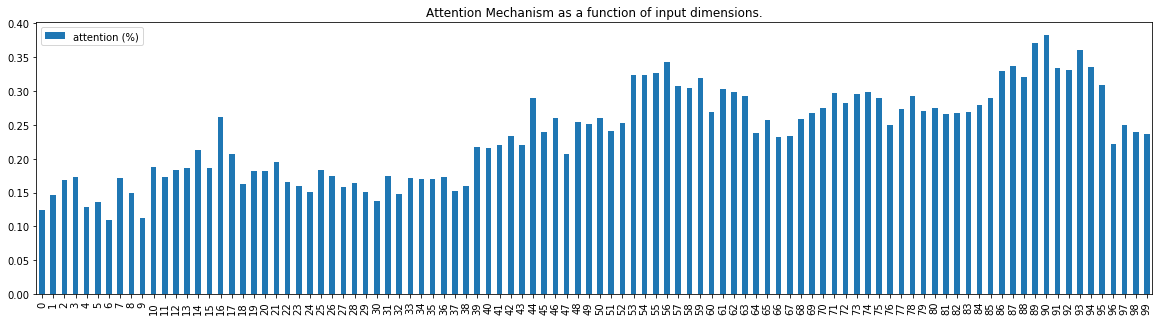

of(0) Women(1) Across(2) the(3) Nation(4) ,(5) SWAN(6) ).(7) Interview(8) data(9) were(10) used(11) to(12) ((13) i(14) )(15) determine(16) the(17) prevalence(18) of(19) self(20) -(21) reported(22) POF(23) overall(24) and(25) by(26) ethnic(27) group(28) ,(29) and(30) ((31) ii(32) )(33) assess(34) the(35) association(36) of(37) POF(38) with(39) selected(40) self(41) -(42) reported(43) variables(44) related(45) to(46) health(47) .(48) Cases(49) of(50) POF(51) included(52) only(53) women(54) with(55) no(56) discernible(57) cause(58) for(59) POF(60) .(61) RESULTS(62) :(63) POF(64) was(65) reported(66) by(67) 1(68) .(69) 1(70) %(71) ((72) 126(73) /(74) 11(75) 652(76) )(77) of(78) women(79) .(80) By(81) ethnicity(82) ,(83) 1(84) .(85) 0(86) %(87) ((88) 95(89) %(90) CI(91) ,(92) 0(93) .(94) 7(95) ±(96) 1(97) .(98) 4(99)


<Figure size 720x5760 with 0 Axes>

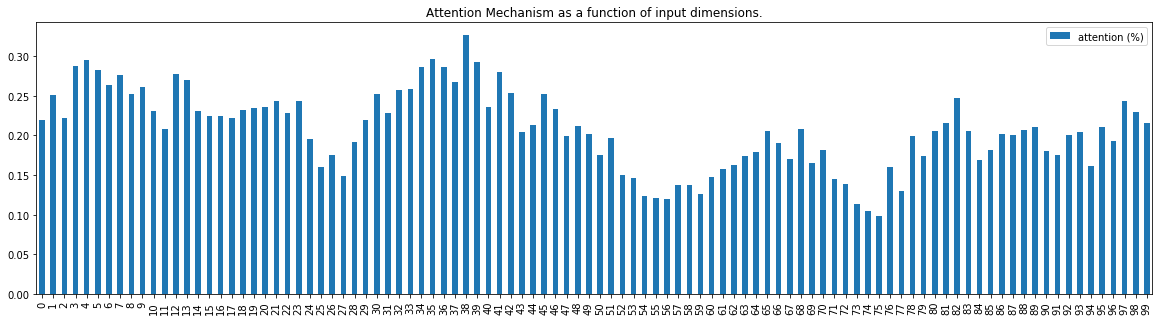

32(0) .(1) Richters(2) J(3) .(4) Depressed(5) mothers(6) as(7) informants(8) about(9) their(10) children(11) :(12) a(13) critical(14) re(15) -(16) view(17) of(18) the(19) evidence(20) for(21) distortion(22) .(23) Psychol(24) Bull(25) .(26) 1992(27) ;(28) 112(29) :(30) 485(31) -(32) 499(33) .(34) 33(35) .(36) Guyer(37) B(38) ,(39) Hughart(40) N(41) ,(42) Strobino(43) D(44) ,(45) Jones(46) A(47) ,(48) Scharfstein(49) D(50) .(51) Assessing(52) the(53) impact(54) of(55) pediatric(56) -(57) based(58) developmental(59) services(60) on(61) infants(62) ,(63) families(64) ,(65) and(66) clinicians(67) :(68) challenges(69) to(70) evaluating(71) the(72) Healthy(73) Steps(74) Program(75) .(76) Pediatrics(77) .(78) 2000(79) ;(80) 105(81) :(82) e33(83) online(84) series(85) .(86) Available(87) at(88) :(89) http(90) ://(91) www(92) .(93) pediatrics(94) .(95) org(96) .(97) Accessed(98) November(99)


<Figure size 720x5760 with 0 Axes>

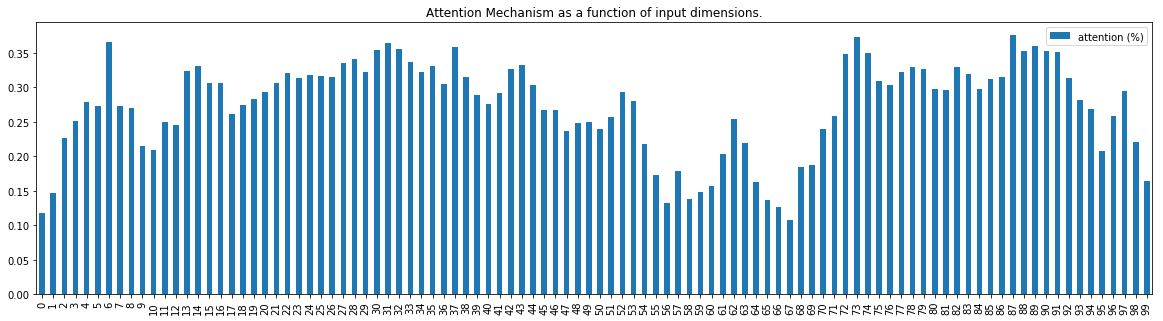

secondary(0) school(1) ((2) age(3) 18(4) )(5) were(6) followed(7) into(8) middle(9) adulthood(10) .(11) Structural(12) equation(13) models(14) estimated(15) the(16) associations(17) between(18) age(19) -(20) 18(21) characteristics(22) and(23) current(24) drinking(25) and(26) heavy(27) drinking(28) at(29) ages(30) 22(31) ,(32) 26(33) and(34) 35(35) and(36) symptoms(37) of(38) AUDs(39) at(40) age(41) 35(42) .(43) Participants(44) The(45) sample(46) consisted(47) of(48) 21(49) 137(50) respondents(51) from(52) 11(53) senior(54) year(55) cohorts(56) ((57) 1976(58) ­(59) 86(60) )(61) from(62) the(63) Monitoring(64) the(65) Future(66) study(67) .(68) Findings(69) Many(70) predictor(71) variables(72) had(73) stable(74) associations(75) with(76) alcohol(77) use(78) over(79) time(80) ,(81) although(82) their(83) ability(84) to(85) explain(86) variance(87) in(88) alcohol(89) use(90) declined(91) with(92) increasing(93) time(94) lags(95) .(96) Being(97) white(98) predicted(99)


<Figure size 720x5760 with 0 Axes>

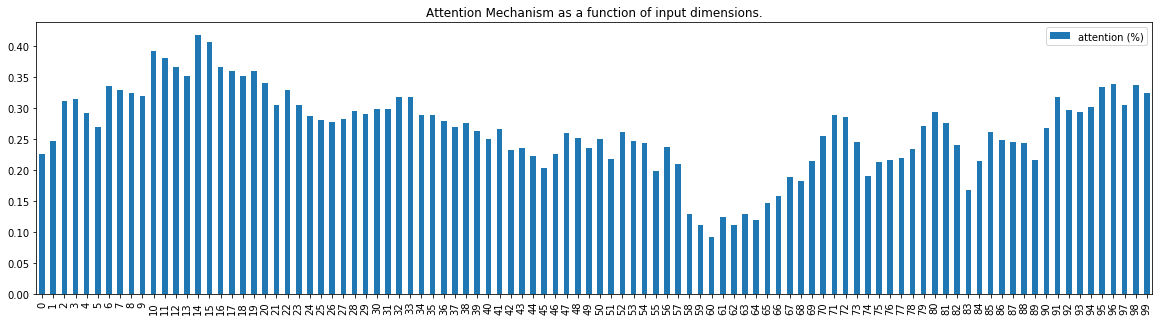

Alcohol(0) abuse(1) /(2) dependence(3) items(4) 3741(5) 0(6) .(7) 17(8) ((9) 0(10) .(11) 41(12) )(13) 0(14) .(15) 00(16) to(17) 2(18) .(19) 00(20) aThe(21) number(22) of(23) delinquent(24) activities(25) during(26) the(27) previous(28) year(29) residualized(30) after(31) regression(32) on(33) mother(34) '(35) s(36) age(37) when(38) she(39) completed(40) the(41) Self(42) -(43) Reported(44) Delinquency(45) Interview(46) .(47) Table(48) 2(49) .(50) Prenatal(51) Alcohol(52) Exposure(53) in(54) Offspring(55) From(56) the(57) National(58) Longitudinal(59) Survey(60) of(61) Youth(62) Alcohol(63) Response(64) Calculated(65) d(66) /(67) wk(68) Offspring(69) ,(70) No(71) .(72) (%)(73) Entire(74) Sample(75) Sibling(76) Comparison(77) Sample(78) Never(79) 0(80) .(81) 00(82) 5958(83) ((84) 63(85) .(86) 7(87) )(88) 1497(89) ((90) 43(91) .(92) 4(93) )(94) 1(95) /(96) mo(97) 0(98) .(99)


<Figure size 720x5760 with 0 Axes>

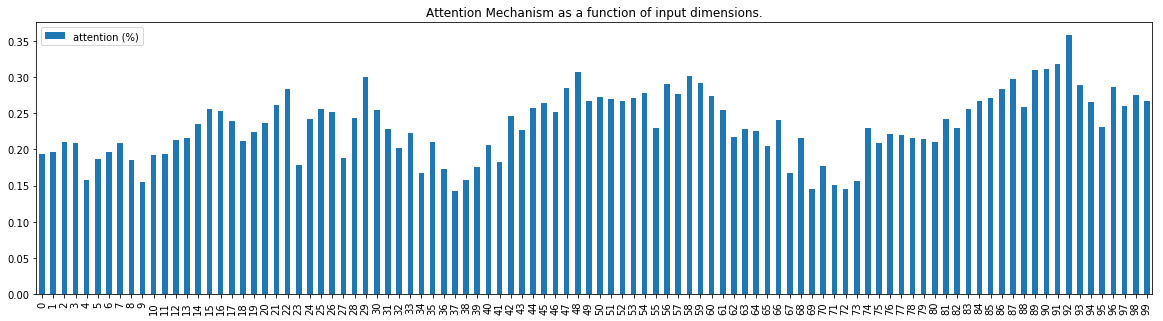

Reducing(0) deviant(1) arousal(2) in(3) juvenile(4) sex(5) offenders(6) using(7) vicarious(8) sensitization(9) .(10) Journal(11) of(12) Interpersonal(13) Violence(14) ,(15) 12(16) ,(17) 704(18) ­(19) 728(20) .(21) 76(22) ZIMRING(23) ET(24) AL(25) .(26) Widom(27) ,(28) C(29) .(30) S(31) .(32) ((33) 1989(34) ).(35) The(36) cycle(37) of(38) violence(39) .(40) Science(41) ,(42) 244(43) ,(44) 160(45) ­(46) 166(47) .(48) Wolfgang(49) ,(50) M(51) .(52) E(53) .,(54) Figlio(55) ,(56) R(57) .(58) M(59) .,(60) &(61) Sellin(62) ,(63) T(64) .(65) ((66) 1972(67) ).(68) Delinquency(69) in(70) a(71) birth(72) cohort(73) .(74) Chicago(75) :(76) University(77) of(78) Chicago(79) Press(80) .(81) Wolfgang(82) ,(83) M(84) .(85) E(86) .,(87) Thornberry(88) ,(89) T(90) .(91) P(92) .,(93) &(94) Figlio(95) ,(96) R(97) .(98) M(99)


<Figure size 720x5760 with 0 Axes>

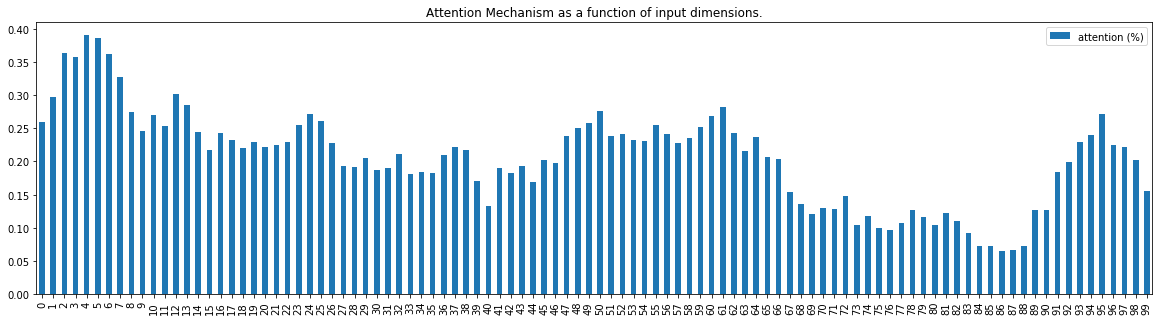

on(0) allele(1) frequency(2) and(3) genotype(4) prevalence(5) provide(6) a(7) valuable(8) resource(9) for(10) future(11) epidemi(12) -(13) ologic(14) studies(15) in(16) public(17) health(18) in(19) the(20) United(21) States(22) .(23) alleles(24) ;(25) continental(26) population(27) groups(28) ;(29) ethnic(30) groups(31) ;(32) genetics(33) ,(34) population(35) ;(36) genotype(37) ;(38) nutrition(39) surveys(40) ;(41) polymor(42) -(43) phism(44) ,(45) genetic(46) ;(47) prevalence(48) Abbreviations(49) :(50) CDC(51) ,(52) Centers(53) for(54) Disease(55) Control(56) and(57) Prevention(58) ;(59) CI(60) ,(61) confidence(62) interval(63) ;(64) NCHS(65) ,(66) National(67) Center(68) for(69) Health(70) Statistics(71) ;(72) NCI(73) ,(74) National(75) Cancer(76) Institute(77) ;(78) NHANES(79) III(80) ,(81) Third(82) National(83) Health(84) and(85) Nutrition(86) Examination(87) Survey(88) ;(89) SNP(90) ,(91) single(92) nucleotide(93) polymorphism(94) .(95) Completion(96) of(97) the(98) human(99)


<Figure size 720x5760 with 0 Axes>

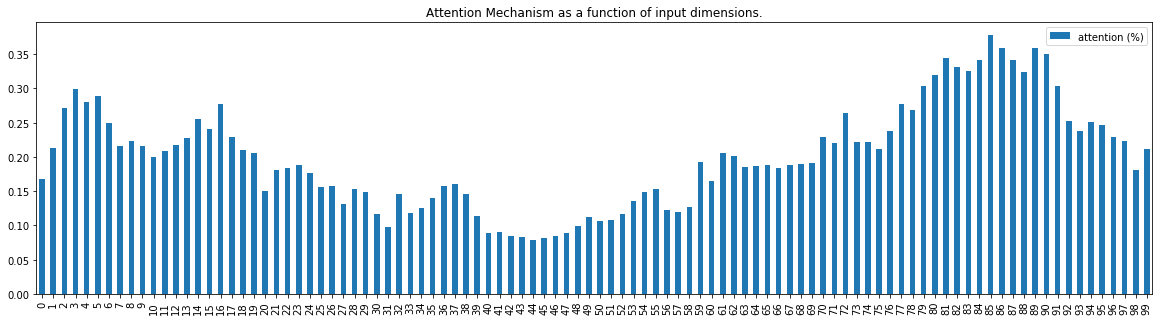

American(0) and(1) depressive(2) symptoms(3) for(4) older(5) Mexican(6) Americans(7) in(8) the(9) south(10) western(11) United(12) States(13) .(14) Design(15) :(16) A(17) population(18) based(19) study(20) of(21) older(22) non(23) -(24) institutionalised(25) Mexican(26) Americans(27) from(28) the(29) baseline(30) assessment(31) ((32) 1993(33) /(34) 94(35) )(36) of(37) the(38) Hispanic(39) established(40) population(41) for(42) the(43) epidemiologic(44) study(45) of(46) the(47) elderly(48) ((49) H(50) -(51) EPESE(52) )(53) merged(54) with(55) 1990(56) census(57) data(58) .(59) Setting(60) :(61) Five(62) south(63) western(64) states(65) in(66) the(67) United(68) States(69) .(70) Participants(71) :(72) 3050(73) Mexican(74) Americans(75) aged(76) 65(77) years(78) or(79) older(80) .(81) Main(82) results(83) :(84) There(85) was(86) a(87) strong(88) correlation(89) between(90) the(91) percentage(92) of(93) neighbourhood(94) residents(95) living(96) in(97) poverty(98) and(99)


<Figure size 720x5760 with 0 Axes>

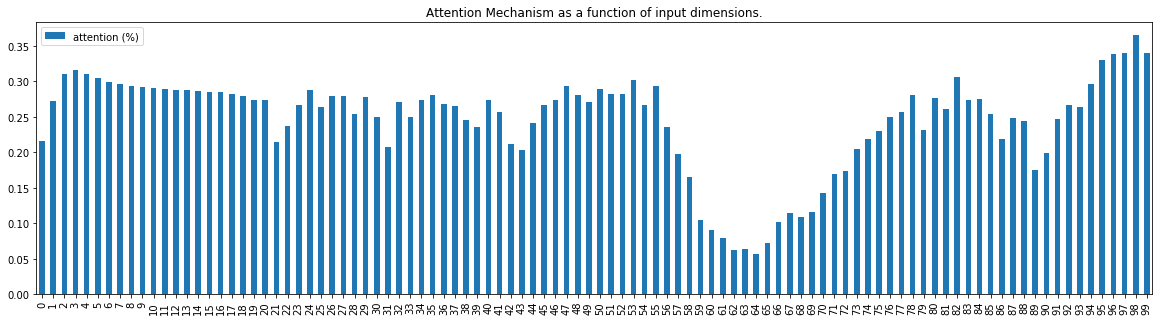

.(0) .(1) .(2) .(3) .(4) .(5) .(6) .(7) .(8) .(9) .(10) .(11) .(12) .(13) .(14) .(15) .(16) .(17) .(18) .(19) Thorax(20) 2003(21) ;(22) 58(23) :(24) 388(25) ­(26) 393(27) Background(28) :(29) A(30) study(31) was(32) undertaken(33) to(34) define(35) the(36) risk(37) of(38) death(39) among(40) a(41) national(42) cohort(43) of(44) US(45) adults(46) both(47) with(48) and(49) without(50) lung(51) disease(52) .(53) Methods(54) :(55) Participants(56) in(57) the(58) first(59) National(60) Health(61) and(62) Nutrition(63) Examination(64) Survey(65) ((66) NHANES(67) I(68) )(69) fol(70) -(71) lowed(72) for(73) up(74) to(75) 22(76) years(77) were(78) studied(79) .(80) Subjects(81) were(82) classified(83) using(84) a(85) modification(86) of(87) the(88) Global(89) Ini(90) -(91) tiative(92) for(93) Chronic(94) Obstructive(95) Lung(96) Disease(97) criteria(98) for(99)


<Figure size 720x5760 with 0 Axes>

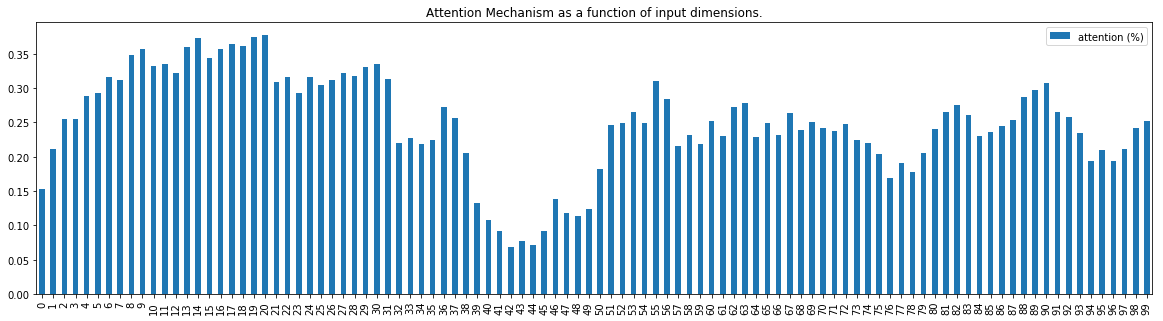

study(0) examined(1) the(2) reported(3) intake(4) of(5) foods(6) and(7) nutrients(8) ,(9) and(10) biomarkers(11) of(12) dietary(13) exposure(14) and(15) cardiovascular(16) disease(17) in(18) relation(19) to(20) history(21) of(22) trying(23) to(24) lose(25) weight(26) .(27) Methods(28) :(29) Dietary(30) ,(31) anthropometric(32) and(33) biochemical(34) data(35) were(36) from(37) the(38) third(39) National(40) Health(41) and(42) Nutrition(43) Examination(44) Survey(45) ((46) 1988(47) ­(48) 1994(49) ),(50) n(51) ¼(52) 13(53) 092(54) .(55) The(56) history(57) of(58) attempting(59) weight(60) loss(61) variable(62) was(63) created(64) as(65) follows(66) :(67) trying(68) to(69) lose(70) currently(71) and(72) tried(73) in(74) the(75) past(76) 12(77) months(78) ((79) Y(80) =(81) Y(82) );(83) trying(84) to(85) lose(86) currently(87) ,(88) but(89) not(90) tried(91) in(92) the(93) past(94) 12(95) months(96) ((97) Y(98) =(99)


<Figure size 720x5760 with 0 Axes>

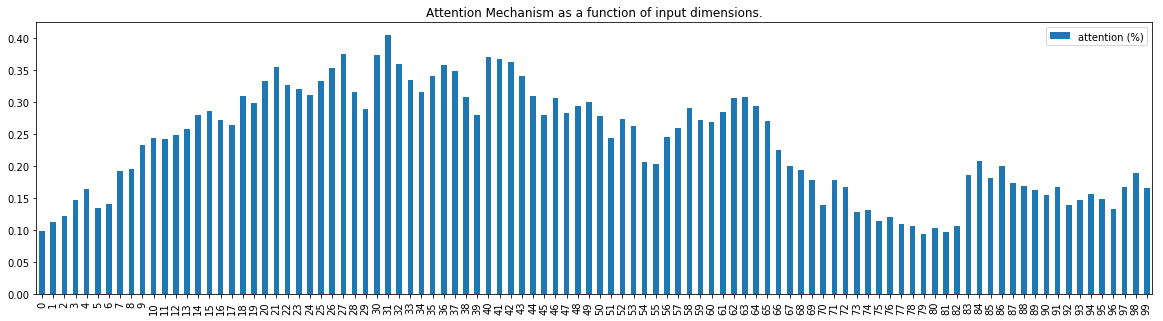

((0) NHANES(1) )(2) 2003(3) to(4) 2006(5) dataset(6) to(7) estimate(8) the(9) numbers(10) of(11) US(12) adults(13) in(14) each(15) of(16) 3(17) risk(18) groups(19) :(20) low(21) short(22) -(23) term(24) CHD(25) /(26) low(27) lifetime(28) CVD(29) ,(30) low(31) short(32) -(33) term(34) CHD(35) /(36) high(37) lifetime(38) CVD(39) ,(40) and(41) high(42) short(43) -(44) term(45) CHD(46) predicted(47) risk(48) .(49) Methods(50) Study(51) Participants(52) We(53) included(54) CVD(55) -(56) free(57) ,(58) nonpregnant(59) participants(60) ages(61) 20(62) to(63) 79(64) years(65) who(66) completed(67) a(68) mobile(69) examination(70) in(71) the(72) 2003(73) to(74) 2004(75) or(76) 2005(77) to(78) 2006(79) NHANES(80) ((81) n7396(82) ),(83) which(84) provided(85) representative(86) samples(87) of(88) the(89) noninstitutionalized(90) US(91) population9(92) targeted(93) by(94) the(95) NCEP(96) /(97) ATP(98) III(99)


<Figure size 720x5760 with 0 Axes>

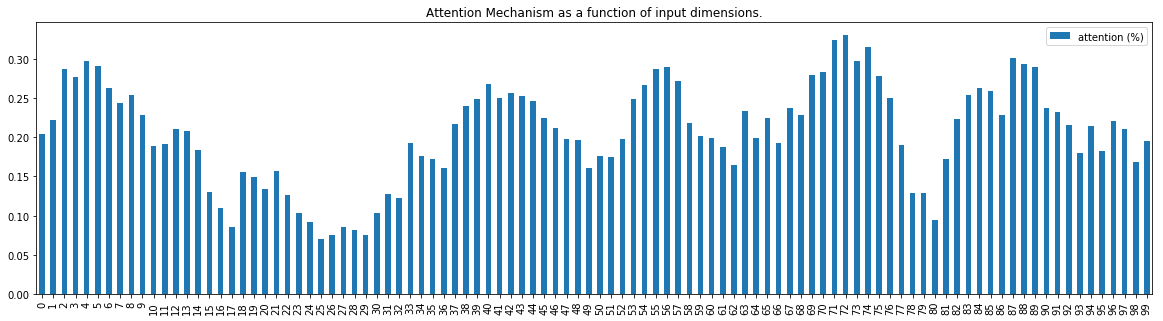

.(0) Seventy(1) percent(2) ((3) 14(4) ,(5) 407(6) of(7) 20(8) ,(9) 729(10) persons(11) )(12) of(13) the(14) NHANES(15) I(16) cohort(17) were(18) medically(19) examined(20) .(21) The(22) NHANES(23) I(24) Epidemiologic(25) Follow(26) -(27) up(28) Study(29) ((30) NHEFS(31) )(32) is(33) a(34) longitudinal(35) study(36) of(37) participants(38) who(39) were(40) between(41) 25(42) and(43) 74(44) years(45) old(46) during(47) the(48) 1971(49) ­(50) 1975(51) interviews(52) .(53) 15(54) ,(55) 16(56) The(57) first(58) follow(59) -(60) up(61) study(62) was(63) conducted(64) in(65) 1982(66) and(67) included(68) all(69) persons(70) aged(71) 5(72) ­(73) 74(74) years(75) at(76) the(77) NHANES(78) I(79) assessment(80) ((81) n(82) =(83) 14(84) ,(85) 407(86) ).(87) Participants(88) were(89) subsequently(90) interviewed(91) in(92) 1986(93) ,(94) 1987(95) ,(96) and(97) 1992(98) .(99)


<Figure size 720x5760 with 0 Axes>

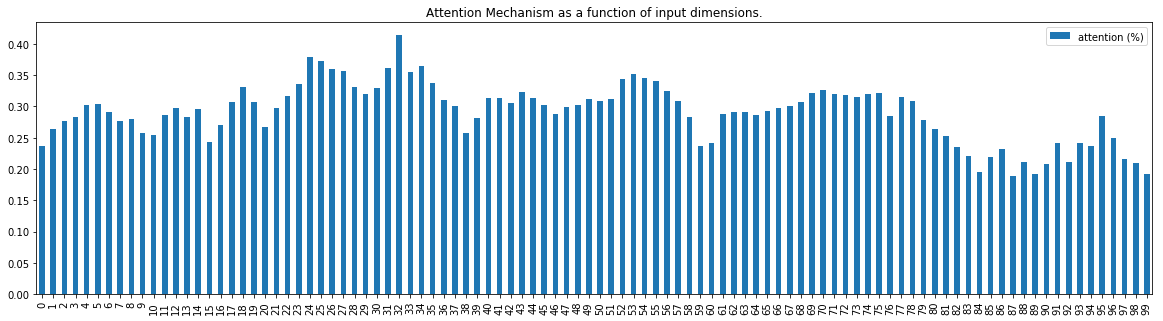

influence(0) weight(1) loss(2) motivation(3) ,(4) especially(5) in(6) women(7) ,(8) including(9) appearance24(10) ,(11) 26(12) and(13) body(14) image(15) .(16) 24(17) There(18) -(19) fore(20) ,(21) it(22) is(23) not(24) entirely(25) surprising(26) that(27) a(28) minority(29) of(30) individuals(31) were(32) attempting(33) to(34) lose(35) weight(36) .(37) Physician(38) advice(39) also(40) has(41) an(42) important(43) role(44) in(45) the(46) decision(47) to(48) lose(49) weight(50) .(51) 24(52) Therefore(53) ,(54) it(55) is(56) important(57) for(58) health(59) professionals(60) to(61) understand(62) the(63) true(64) prevalence(65) of(66) long(67) -(68) term(69) weight(70) loss(71) ,(72) as(73) it(74) may(75) help(76) to(77) change(78) the(79) underlying(80) beliefs(81) and(82) influence(83) clinical(84) practice(85) .(86) Foster(87) and(88) colleagues(89) ob(90) -(91) served(92) that(93) physicians(94) rated(95) the(96) treatment(97) of(98) obesity(99)


<Figure size 720x5760 with 0 Axes>

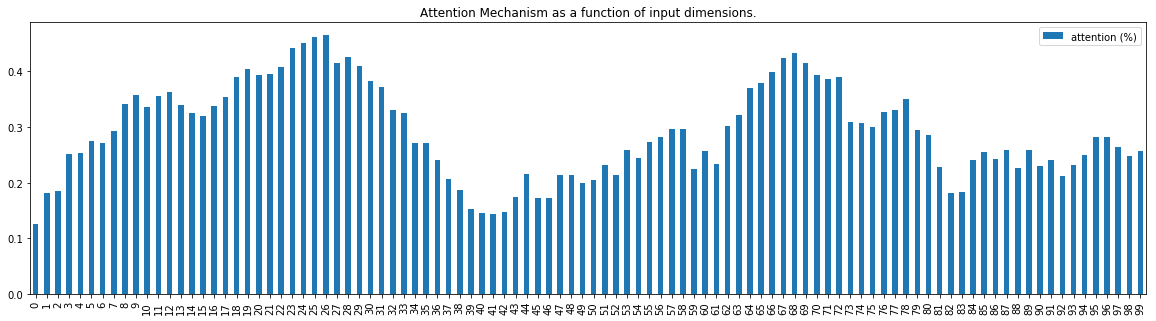

hemihypertro(0) -(1) phy(2) ,(3) and(4) familial(5) adenomatous(6) polyposis(7) ,(8) none(9) of(10) which(11) have(12) unique(13) ICD(14) -(15) 9(16) codes(17) .(18) 27(19) The(20) relatively(21) low(22) incidence(23) of(24) these(25) conditions(26) did(27) not(28) allow(29) us(30) to(31) examine(32) their(33) association(34) with(35) hepatoblastoma(36) in(37) the(38) multiple(39) cause(40) of(41) death(42) database(43) .(44) Recent(45) reports(46) from(47) the(48) United(49) States(50) and(51) Japan(52) have(53) suggested(54) an(55) increased(56) incidence(57) of(58) hepato(59) -(60) blastoma(61) in(62) extremely(63) low(64) birth(65) weight(66) infants(67) .(68) 28(69) -(70) 31(71) Be(72) -(73) cause(74) birth(75) weight(76) is(77) not(78) collected(79) in(80) the(81) SEER(82) database(83) ,(84) we(85) could(86) not(87) analyze(88) this(89) association(90) .(91) Fig(92) .(93) 3(94) .(95) Age(96) -(97) adjusted(98) incidence(99)


<Figure size 720x5760 with 0 Axes>

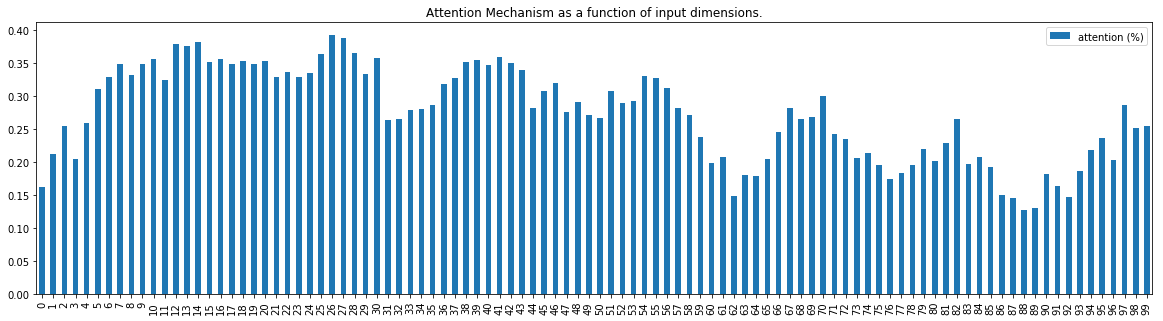

.(0) ((1) Top(2) )-(3) :(4) 0(5) -(6) 14(7) years(8) ;(9) -(10) -:(11) 15(12) -(13) 34(14) years(15) ;(16) ---:(17) 35(18) -(19) 54(20) years(21) ;(22) ---:(23) 55(24) +(25) 34(26) -(27) year(28) and(29) 35(30) -%-(31) year(32) age(33) groups(34) also(35) decreased(36) ,(37) al(38) -(39) though(40) less(41) significantly(42) .(43) Analysis(44) of(45) different(46) geographic(47) regions(48) showed(49) a(50) decrease(51) in(52) mortality(53) rate(54) in(55) each(56) region(57) between(58) the(59) years(60) 1979and(61) 1988(62) ((63) Fig(64) .(65) 1(66) ).(67) The(68) decreases(69) were(70) great(71) -(72) est(73) in(74) the(75) South(76) and(77) West(78) .(79) Mortality(80) Characteristics(81) :(82) 1988(83) In(84) the(85) multiple(86) -(87) cause(88) data(89) ,(90) 2205(91) Hodgkin(92) disease(93) deaths(94) during(95) 1988(96) were(97) reported(98) .(99)


<Figure size 720x5760 with 0 Axes>

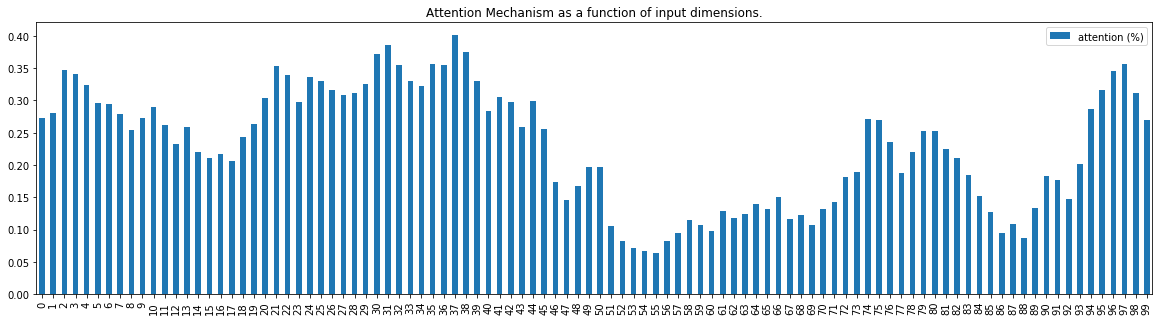

decreasing(0) trends(1) in(2) the(3) number(4) of(5) patients(6) who(7) report(8) receiving(9) weight(10) loss(11) advice(12) from(13) a(14) health(15) -(16) care(17) provider(18) ((19) 4(20) ).(21) Prior(22) studies(23) ,(24) how(25) -(26) ever(27) ,(28) did(29) not(30) have(31) an(32) ethnically(33) diverse(34) population(35) and(36) were(37) limited(38) in(39) assessing(40) whether(41) these(42) trends(43) were(44) similar(45) among(46) minority(47) patients(48) .(49) Using(50) National(51) Health(52) and(53) Nutrition(54) Examination(55) Survey(56) ((57) NHANES(58) )(59) data(60) ,(61) we(62) ((63) i(64) )(65) examined(66) trends(67) in(68) provider(69) diagnosis(70) of(71) overweight(72) ((73) defined(74) as(75) participant(76) report(77) of(78) being(79) told(80) they(81) were(82) overweight(83) by(84) a(85) health(86) -(87) care(88) professional(89) ),(90) ((91) ii(92) )(93) determined(94) if(95) there(96) were(97) differences(98) in(99)


<Figure size 720x5760 with 0 Axes>

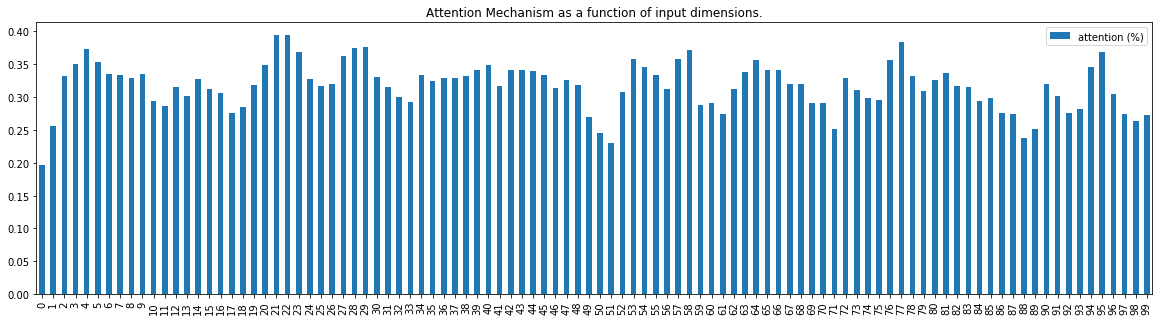

3(0) ).(1) However(2) ,(3) there(4) was(5) an(6) indication(7) of(8) an(9) upturn(10) in(11) risk(12) trend(13) in(14) the(15) highest(16) quartile(17) of(18) serum(19) selenium(20) ,(21) particularly(22) after(23) adjusting(24) for(25) cardiovascular(26) risk(27) factors(28) .(29) The(30) fully(31) adjusted(32) odds(33) ratios(34) for(35) peripheral(36) arterial(37) disease(38) comparing(39) selenium(40) quartiles(41) 2(42) ,(43) 3(44) ,(45) and(46) 4(47) with(48) the(49) lowest(50) quartile(51) were(52) 0(53) .(54) 75(55) ((56) 95(57) %(58) confi(59) -(60) dence(61) interval(62) :(63) 0(64) .(65) 37(66) ,(67) 1(68) .(69) 52(70) ),(71) 0(72) .(73) 58(74) ((75) 95(76) %(77) confidence(78) interval(79) :(80) 0(81) .(82) 28(83) ,(84) 1(85) .(86) 19(87) ),(88) and(89) 0(90) .(91) 67(92) ((93) 95(94) %(95) confidence(96) interval(97) :(98) 0(99)


<Figure size 720x5760 with 0 Axes>

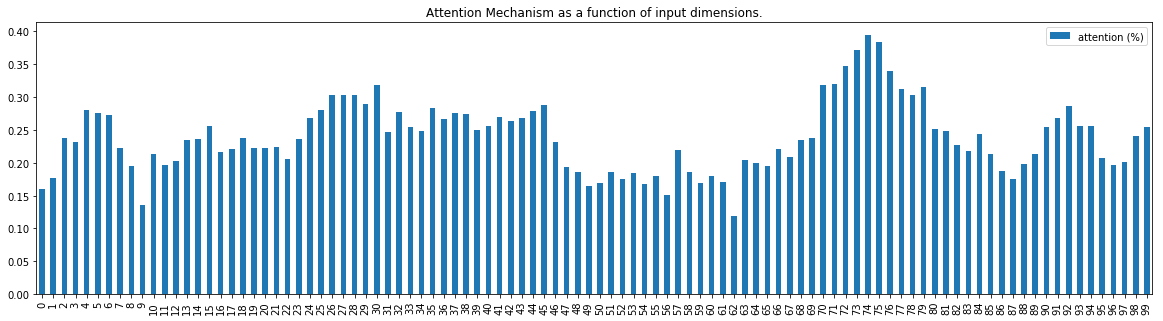

specific(0) plans(1) to(2) halt(3) it(4) .(5) We(6) feel(7) our(8) survey(9) ,(10) by(11) providing(12) relevant(13) information(14) on(15) CKD(16) in(17) one(18) of(19) the(20) most(21) populous(22) European(23) countries(24) ,(25) is(26) an(27) important(28) ad(29) -(30) dition(31) to(32) the(33) knowledge(34) base(35) on(36) this(37) still(38) overlooked(39) prob(40) -(41) lem(42) and(43) could(44) fuel(45) the(46) interest(47) of(48) health(49) agencies(50) in(51) imple(52) -(53) menting(54) preventive(55) programs(56) .(57) Major(58) findings(59) of(60) the(61) study(62) are(63) as(64) follow(65) :(66) ((67) 1(68) )(69) abnormal(70) serum(71) creatinine(72) values(73) are(74) less(75) frequent(76) in(77) persons(78) from(79) Italy(80) than(81) in(82) persons(83) from(84) the(85) United(86) States(87) ;(88) ((89) 2(90) )(91) the(92) preva(93) -(94) lence(95) of(96) CKD(97) is(98) higher(99)


<Figure size 720x5760 with 0 Axes>

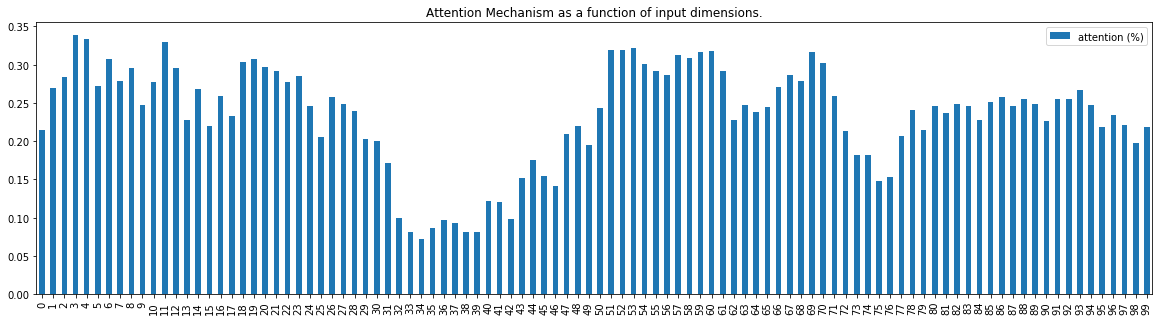

or(0) without(1) injury(2) ).(3) This(4) study(5) further(6) examined(7) whether(8) childhood(9) ADHD(10) symptoms(11) predict(12) IPV(13) when(14) comorbidity(15) with(16) CD(17) is(18) considered(19) .(20) METHODS(21) DATA(22) SOURCE(23) AND(24) STUDY(25) SAMPLE(26) We(27) used(28) data(29) from(30) the(31) National(32) Longitudinal(33) Study(34) of(35) Ado(36) -(37) lescent(38) Health(39) ((40) Add(41) Health(42) ),(43) a(44) longitudinal(45) study(46) following(47) a(48) nationally(49) representative(50) probability(51) sample(52) of(53) adolescents(54) in(55) grades(56) 7(57) through(58) 12(59) in(60) the(61) 1994(62) -(63) 1995(64) school(65) year(66) .(67) 29(68) There(69) are(70) 3(71) waves(72) of(73) Add(74) Health(75) data(76) available(77) ,(78) collected(79) from(80) April(81) to(82) December(83) 1995(84) ,(85) from(86) April(87) to(88) August(89) 1996(90) ,(91) and(92) from(93) August(94) 2001(95) to(96) April(97) 2002(98) .(99)


<Figure size 720x5760 with 0 Axes>

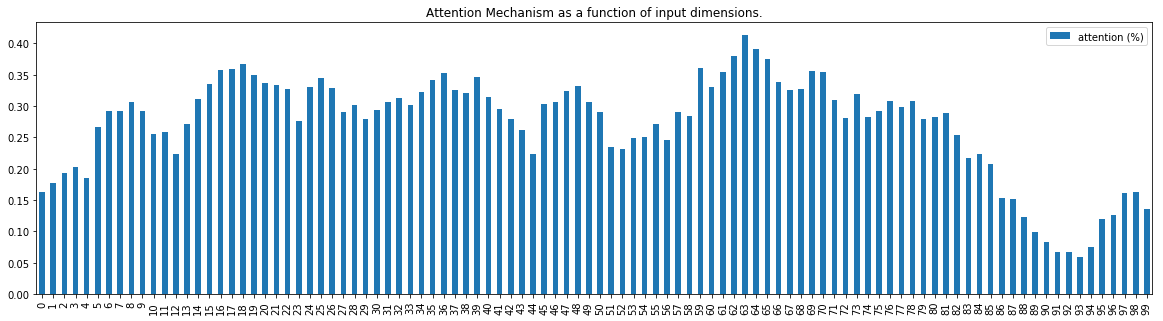

.(0) 2000(1) );(2) many(3) studies(4) ,(5) however(6) ,(7) have(8) been(9) lim(10) -(11) ited(12) by(13) small(14) sample(15) sizes(16) ,(17) lack(18) of(19) adjustment(20) for(21) potential(22) confounders(23) ,(24) lack(25) of(26) standardiza(27) -(28) tion(29) of(30) blood(31) pressure(32) measurements(33) ,(34) or(35) other(36) methodologic(37) limitations(38) .(39) The(40) objective(41) of(42) our(43) study(44) was(45) to(46) investi(47) -(48) gate(49) the(50) association(51) of(52) blood(53) and(54) urine(55) cad(56) -(57) mium(58) levels(59) with(60) blood(61) pressure(62) levels(63) and(64) with(65) the(66) prevalence(67) of(68) hypertension(69) in(70) a(71) representa(72) -(73) tive(74) sample(75) of(76) U(77) .(78) S(79) .(80) adults(81) who(82) participated(83) in(84) the(85) 1999(86) ­(87) 2004(88) National(89) Health(90) and(91) Nutrition(92) Examination(93) Survey(94) ((95) NHANES(96) ).(97) Urine(98) and(99)


<Figure size 720x5760 with 0 Axes>

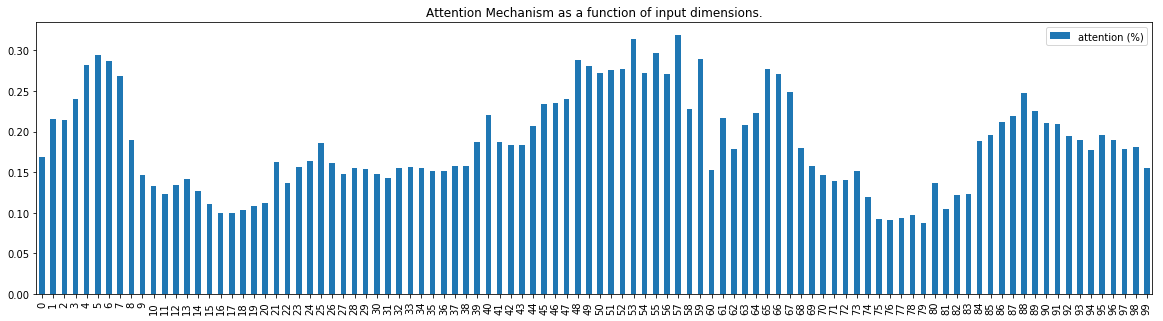

34(0) :(1) 1065(2) ­(3) 70(4) .(5) 23(6) .(7) National(8) Center(9) for(10) Health(11) Statistics(12) .(13) National(14) Health(15) and(16) Nutrition(17) Examination(18) Survey(19) data(20) .(21) Hyattsville(22) ,(23) MD(24) :(25) Centers(26) for(27) Disease(28) Control(29) and(30) Prevention(31) ,(32) US(33) Department(34) of(35) Health(36) and(37) Human(38) Services(39) ,(40) 1999(41) ­(42) 2002(43) .(44) ((45) http(46) ://(47) www(48) .(49) cdc(50) .(51) gov(52) /(53) nchs(54) /(55) about(56) /(57) major(58) /(59) nhanes(60) /(61) datalink(62) .(63) htm(64) ).(65) 24(66) .(67) National(68) Center(69) for(70) Health(71) Statistics(72) .(73) National(74) Health(75) and(76) Nutrition(77) Examination(78) Survey(79) :(80) anthropometry(81) procedures(82) manual(83) .(84) Hyattsville(85) ,(86) MD(87) :(88) Centers(89) for(90) Disease(91) Control(92) and(93) Prevention(94) ,(95) US(96) Department(97) of(98) Health(99)


<Figure size 720x5760 with 0 Axes>

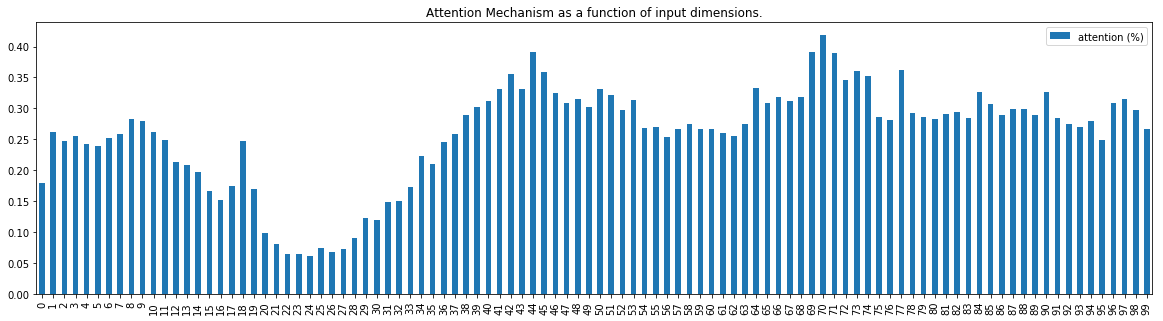

((0) 18(1) þ(2) years(3) of(4) age(5) )(6) with(7) hypertension(8) ((9) prehypertension(10) ,(11) Stage(12) I(13) and(14) Stage(15) II(16) hypertension(17) ).(18) The(19) National(20) Health(21) and(22) Nutrition(23) Exam(24) -(25) ination(26) Survey(27) ((28) NHANES(29) )(30) 1999(31) ­(32) 2000(33) was(34) used(35) .(36) Weight(37) status(38) was(39) categorized(40) as(41) normal(42) /(43) underweight(44) ,(45) over(46) -(47) weight(48) and(49) obese(50) .(51) Physicians(52) '(53) recommendations(54) of(55) and(56) patients(57) '(58) adherence(59) to(60) lifestyle(61) modifications(62) ((63) weight(64) control(65) ,(66) exercise(67) ,(68) sodium(69) intake(70) reduction(71) ,(72) alcohol(73) intake(74) reduction(75) )(76) were(77) examined(78) using(79) descriptive(80) and(81) multivariate(82) analyses(83) ,(84) controlling(85) for(86) weight(87) status(88) ,(89) hypertension(90) stage(91) ,(92) comorbidities(93) and(94) demographic(95) characteristics(96) .(97) About(98) 57(99)


<Figure size 720x5760 with 0 Axes>

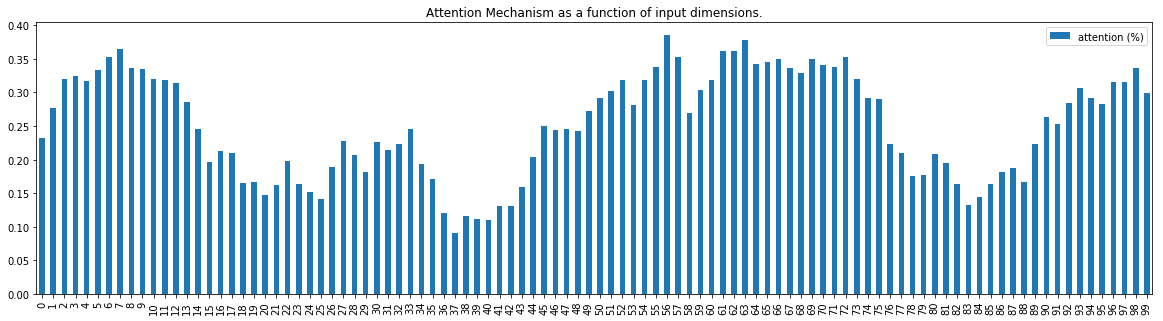

12(0) .(1) 5(2) million(3) population(4) ,(5) approxi(6) -(7) mately(8) 1(9) .(10) 7(11) million(12) met(13) the(14) Diagnostic(15) and(16) Statistical(17) Manual(18) of(19) Mental(20) Disorders(21) ((22) DSM(23) -(24) IV(25) )(26) criteria(27) for(28) abuse(29) or(30) dependence(31) [(32) 2(33) ].(34) The(35) 2007(36) Treatment(37) Episodes(38) Data(39) Set(40) ((41) TEDS(42) )(43) reported(44) that(45) the(46) number(47) of(48) patients(49) admitted(50) to(51) substance(52) abuse(53) treatment(54) facilities(55) due(56) to(57) nonheroin(58) opiate(59) /(60) opioid(61) abuse(62) nearly(63) quadrupled(64) from(65) 23(66) ,(67) 000(68) to(69) more(70) than(71) 90(72) ,(73) 000(74) from(75) 1999(76) to(77) 2007(78) [(79) 3(80) ].(81) The(82) Centers(83) for(84) Disease(85) Control(86) and(87) Prevention(88) reported(89) in(90) 2009(91) that(92) opioid(93) -(94) related(95) poisoning(96) deaths(97) have(98) more(99)


<Figure size 720x5760 with 0 Axes>

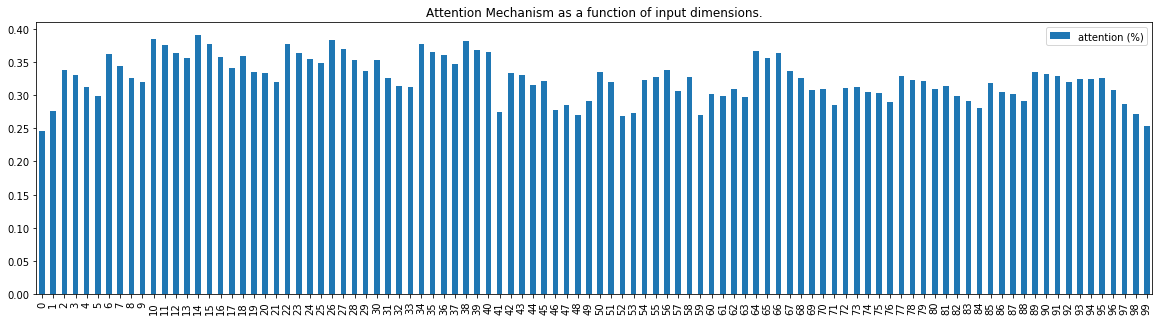

18(0) ,(1) 0(2) .(3) 21(4) )(5) 0(6) .(7) 17(8) ((9) 0(10) .(11) 16(12) ,(13) 0(14) .(15) 19(16) )*(17) 0(18) .(19) 18(20) ((21) 0(22) .(23) 16(24) ,(25) 0(26) .(27) 19(28) )*(29) 0(30) .(31) 16(32) ((33) 0(34) .(35) 15(36) ,(37) 0(38) .(39) 18(40) )***(41) 0(42) .(43) 001(44) Fasting(45) sub(46) -(47) sample(48) ((49) n(50) ¼(51) 2118(52) )(53) Fasting(54) triglycerides(55) ,(56) mmol(57) /(58) La(59) 1(60) .(61) 30(62) ((63) 0(64) .(65) 90(66) ,(67) 1(68) .(69) 96(70) )(71) Total(72) 1(73) .(74) 22(75) ((76) 1(77) .(78) 16(79) ,(80) 1(81) .(82) 28(83) )(84) 1(85) .(86) 34(87) ((88) 1(89) .(90) 27(91) ,(92) 1(93) .(94) 42(95) )*(96) 1(97) .(98) 41(99)


<Figure size 720x5760 with 0 Axes>

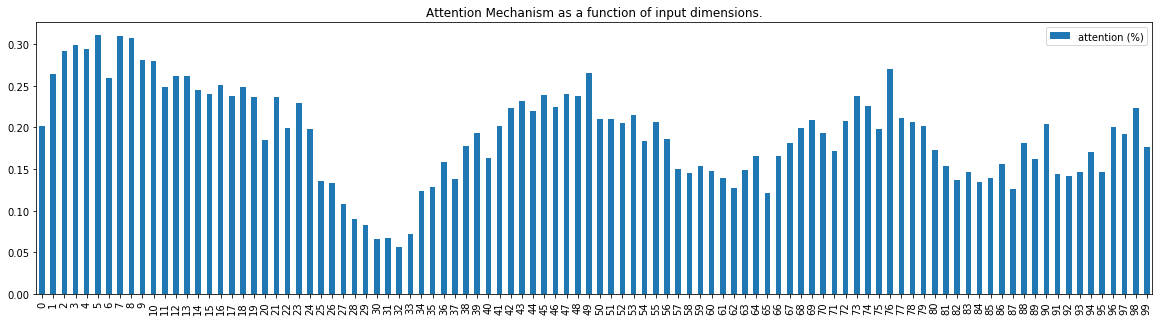

quality(0) .(1) The(2) objective(3) of(4) this(5) study(6) was(7) to(8) examine(9) the(10) association(11) between(12) overall(13) diet(14) quality(15) and(16) self(17) -(18) reported(19) disability(20) .(21) Setting(22) :(23) the(24) 1999(25) ­(26) 2004(27) National(28) Health(29) and(30) Nutrition(31) Examination(32) Survey(33) ((34) NHANES(35) ).(36) Subjects(37) :(38) a(39) nationally(40) representative(41) sample(42) of(43) Americans(44) 60(45) years(46) .(47) Methods(48) :(49) overall(50) diet(51) quality(52) was(53) assessed(54) using(55) the(56) United(57) States(58) Department(59) of(60) Agriculture(61) '(62) s(63) ((64) USDA(65) )(66) Healthy(67) Eating(68) Index(69) -(70) 2005(71) ((72) HEI(73) -(74) 2005(75) ).(76) Self(77) -(78) reported(79) measures(80) of(81) disability(82) included(83) activities(84) of(85) daily(86) living(87) ((88) ADLs(89) ),(90) instrumental(91) activities(92) of(93) daily(94) living(95) ((96) IADLs(97) ),(98) leisure(99)


<Figure size 720x5760 with 0 Axes>

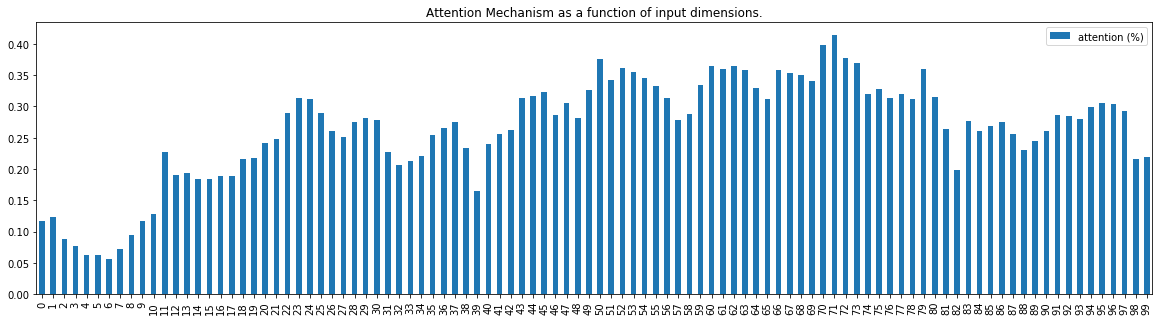

-(0) 2008(1) National(2) Health(3) and(4) Nutrition(5) Examination(6) Surveys(7) ((8) NHANES(9) )(10) were(11) used(12) to(13) examine(14) the(15) prevalence(16) of(17) thrombocytopenia(18) among(19) HCV(20) -(21) infected(22) individuals(23) in(24) the(25) United(26) States(27) .(28) Results(29) :(30) Among(31) 467(32) HCV(33) -(34) infected(35) individuals(36) in(37) the(38) survey(39) ((40) weighted(41) population(42) =(43) 3(44) ,(45) 597(46) ,(47) 039(48) ),(49) mean(50) weighted(51) age(52) was(53) 46(54) .(55) 7(56) years(57) ((58) standard(59) deviation(60) =(61) 15(62) .(63) 5(64) )(65) and(66) 61(67) .(68) 7(69) %(70) were(71) male(72) .(73) Overall(74) ,(75) 7(76) .(77) 6(78) %(79) met(80) the(81) study(82) definition(83) of(84) TCP(85) at(86) the(87) 150(88) ×(89) 109(90) /(91) L(92) threshold(93) ;(94) 4(95) .(96) 5(97) %,(98) 2(99)


<Figure size 720x5760 with 0 Axes>

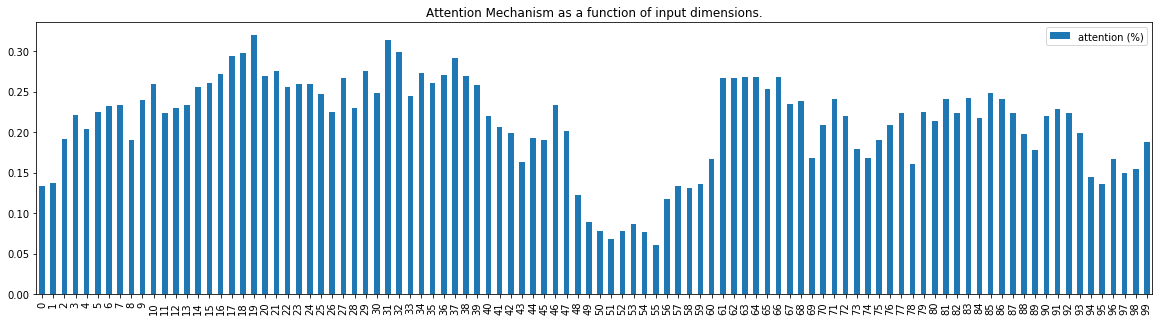

US(0) national(1) sample(2) of(3) youths(4) ,(5) but(6) this(7) study(8) included(9) a(10) re(11) -(12) stricted(13) number(14) of(15) disorders(16) .(17) 7(18) More(19) broad(20) -(21) based(22) na(23) -(24) tional(25) data(26) could(27) help(28) confirm(29) findings(30) from(31) regional(32) stud(33) -(34) ies(35) ,(36) setfutureresearchagendas(37) ,(38) andinformfederalresource(39) allocation(40) decisions(41) for(42) prevention(43) and(44) treatment(45) .(46) The(47) National(48) Comorbidity(49) Survey(50) Replication(51) Ado(52) -(53) lescent(54) Supplement(55) ((56) NCS(57) -(58) A(59) )(60) was(61) carried(62) out(63) to(64) fill(65) these(66) gaps(67) in(68) epidemiological(69) understanding(70) as(71) the(72) first(73) US(74) na(75) -(76) tional(77) survey(78) of(79) adolescents(80) to(81) assess(82) a(83) wide(84) range(85) of(86) DSM(87) -(88) IV(89) disorders(90) using(91) fully(92) structured(93) research(94) diag(95) -(96) nostic(97) interviews(98) .(99)


<Figure size 720x5760 with 0 Axes>

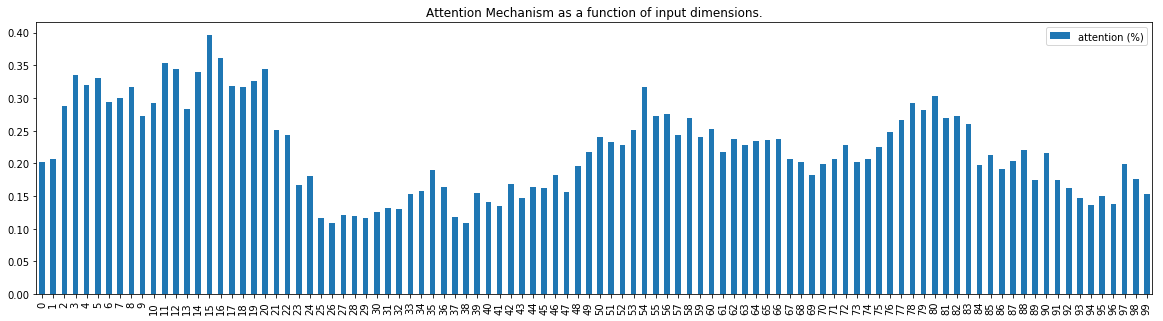

.(0) Criminology(1) ,(2) 45(3) ,(4) 99(5) ­(6) 129(7) .(8) Warner(9) ,(10) B(11) .,(12) Leukefeld(13) ,(14) C(15) .,(16) &(17) Kraman(18) ,(19) P(20) .(21) ((22) 2002(23) ).(24) Informal(25) social(26) control(27) of(28) crime(29) in(30) high(31) drug(32) use(33) neighborhood(34) :(35) Final(36) project(37) report(38) .(39) Washington(40) DC(41) :(42) Department(43) of(44) Justice(45) .(46) Webb(47) ,(48) V(49) .,(50) &(51) Marshall(52) ,(53) C(54) .(55) ((56) 1995(57) ).(58) The(59) relative(60) importance(61) of(62) race(63) and(64) ethnicity(65) on(66) citizen(67) attitudes(68) toward(69) the(70) police(71) .(72) American(73) Journal(74) of(75) Police(76) ,(77) 24(78) ,(79) 45(80) ­(81) 66(82) .(83) Weitzer(84) ,(85) R(86) .(87) ((88) 1999(89) ).(90) Citizens(91) '(92) perceptions(93) of(94) police(95) misconduct(96) :(97) Race(98) and(99)


<Figure size 720x5760 with 0 Axes>

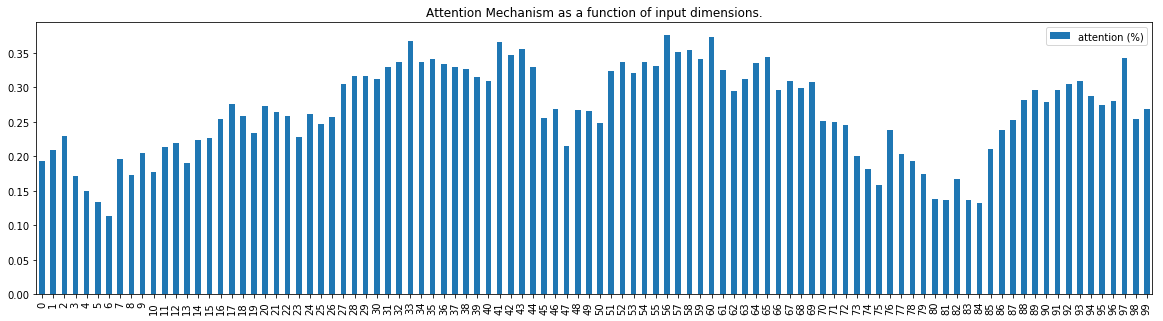

They(0) analyzed(1) the(2) Monitoring(3) the(4) Future(5) surveys(6) from(7) 1992(8) ,(9) 1993(10) ,(11) and(12) 1994(13) ,(14) and(15) found(16) that(17) African(18) Americans(19) were(20) twice(21) as(22) responsive(23) as(24) white(25) adolescents(26) ,(27) with(28) respective(29) estimated(30) elasticities(31) of(32) demand(33) of(34) -(35) 1(36) .(37) 11(38) and(39) -(40) 0(41) .(42) 64(43) .(44) Gruber(45) and(46) Zinman(47) used(48) several(49) data(50) sources(51) to(52) examine(53) the(54) potential(55) differential(56) impact(57) of(58) cigarette(59) prices(60) on(61) youth(62) smoking(63) among(64) different(65) racial(66) groups(67) [(68) 11(69) ].(70) The(71) results(72) of(73) their(74) analyses(75) were(76) mixed(77) :(78) using(79) the(80) ((81) MTF(82) )(83) surveys(84) ,(85) they(86) found(87) that(88) neither(89) white(90) nor(91) non(92) -(93) white(94) younger(95) teenagers(96) were(97) responsive(98) to(99)


<Figure size 720x5760 with 0 Axes>

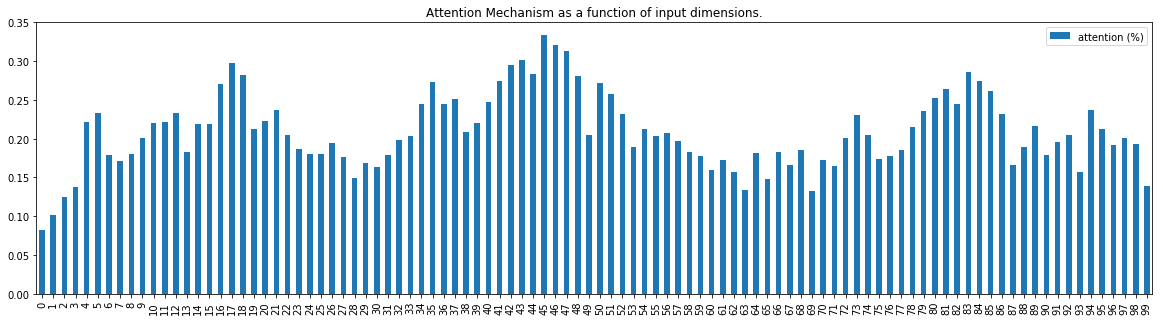

and(0) public(1) health(2) research(3) .(4) J(5) Epidemiol(6) Community(7) Health(8) 2007(9) ;(10) 61(11) :(12) 1098(13) ­(14) 1102(15) .(16) 30(17) .(18) FERRERA(19) M(20) .(21) The(22) `(23) southern(24) model(25) '(26) of(27) welfare(28) in(29) social(30) Eur(31) -(32) ope(33) .(34) J(35) Eur(36) Soc(37) Policy(38) 1996(39) ;(40) 6(41) :(42) 17(43) ­(44) 37(45) .(46) 31(47) .(48) BAMBRA(49) C(50) .(51) `(52) Sifting(53) the(54) wheat(55) from(56) the(57) chaff(58) ':(59) a(60) two(61) -(62) dimen(63) -(64) sional(65) discriminant(66) analysis(67) of(68) welfare(69) state(70) regime(71) theory(72) .(73) Soc(74) Policy(75) Adm(76) 2007(77) ;(78) 41(79) :(80) 1(81) ­(82) 28(83) .(84) 32(85) .(86) EIKEMO(87) TA(88) ,(89) HUISMAN(90) M(91) ,(92) BAMBRA(93) C(94) ,(95) KUNST(96) AE(97) .(98) Health(99)


<Figure size 720x5760 with 0 Axes>

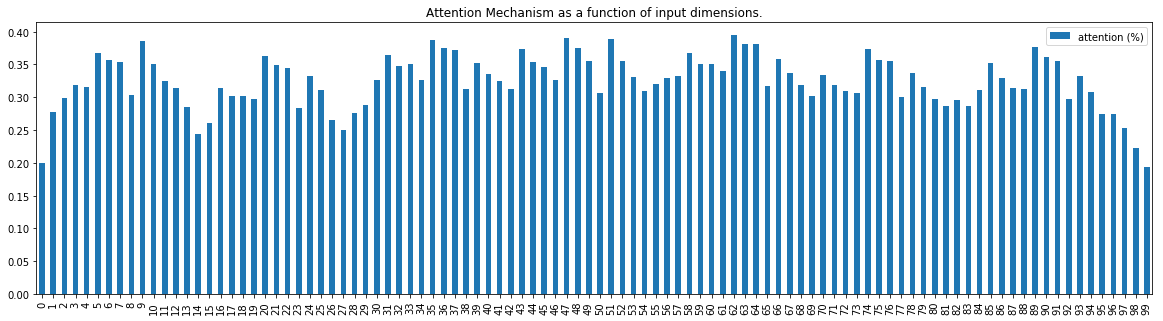

](0) 0(1) .(2) 65(3) ((4) 0(5) .(6) 47(7) ­(8) 0(9) .(10) 88(11) )(12) 1998(13) ­(14) 2001(15) 0(16) .(17) 83(18) ((19) 0(20) .(21) 57(22) ­(23) 1(24) .(25) 09(26) )(27) [(28) 220(29) ](30) 0(31) .(32) 99(33) ((34) 0(35) .(36) 65(37) ­(38) 1(39) .(40) 50(41) )(42) 0(43) .(44) 34(45) ((46) 0(47) .(48) 17(49) ­(50) 0(51) .(52) 51(53) )(54) [(55) 86(56) ](57) 0(58) .(59) 64(60) ((61) 0(62) .(63) 35(64) ­(65) 1(66) .(67) 17(68) )(69) 1(70) .(71) 19(72) ((73) 0(74) .(75) 80(76) ­(77) 1(78) .(79) 58(80) )(81) [(82) 326(83) ](84) 0(85) .(86) 68(87) ((88) 0(89) .(90) 46(91) ­(92) 1(93) .(94) 00(95) )(96) 2002(97) ­(98) 2005(99)


<Figure size 720x5760 with 0 Axes>

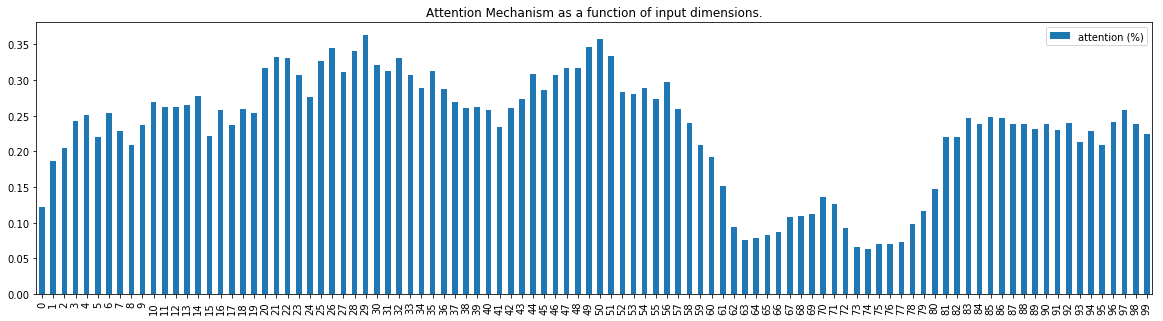

Aims(0) :(1) Anecdotal(2) reports(3) and(4) studies(5) of(6) select(7) populations(8) suggest(9) that(10) the(11) use(12) of(13) proton(14) pump(15) inhibitors(16) ((17) PPIs(18) )(19) has(20) increased(21) since(22) their(23) introduction(24) .(25) We(26) sought(27) to(28) determine(29) recent(30) trends(31) in(32) PPI(33) use(34) in(35) the(36) U(37) .(38) S(39) .(40) outpatient(41) setting(42) and(43) characteristics(44) of(45) patients(46) and(47) physicians(48) that(49) may(50) predict(51) their(52) use(53) .(54) Methods(55) :(56) We(57) used(58) data(59) from(60) the(61) National(62) Ambulatory(63) Medical(64) Care(65) Survey(66) ((67) NAMCS(68) )(69) and(70) the(71) National(72) Hospital(73) Ambulatory(74) Medical(75) Care(76) Survey(77) ((78) NHAMCS(79) )(80) to(81) estimate(82) the(83) prevalence(84) of(85) visits(86) in(87) which(88) patients(89) used(90) PPIs(91) from(92) 2002(93) to(94) 2009(95) .(96) We(97) tested(98) for(99)


<Figure size 720x5760 with 0 Axes>

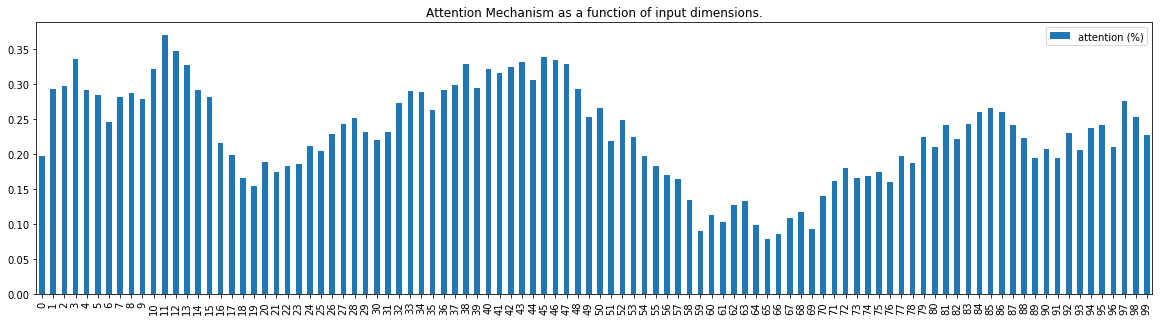

i(0) g(1) i(2) n(3) a(4) l(5) R(6) e(7) s(8) e(9) ar(10) c(11) h(12) open(13) access(14) to(15) scientific(16) and(17) medical(18) research(19) Open(20) Access(21) Full(22) Text(23) Article(24) http(25) ://(26) dx(27) .(28) doi(29) .(30) org(31) /(32) 10(33) .(34) 2147(35) /(36) SAR(37) .(38) S55180(39) Factors(40) associated(41) with(42) reductions(43) in(44) alcohol(45) use(46) between(47) high(48) school(49) and(50) college(51) :(52) an(53) analysis(54) of(55) data(56) from(57) the(58) College(59) Alcohol(60) Study(61) Christopher(62) A(63) Swann1(64) Michelle(65) Sheran1(66) Diana(67) Phelps2(68) 1Department(69) of(70) Economics(71) ,(72) University(73) of(74) North(75) Carolina(76) at(77) Greensboro(78) ,(79) Greensboro(80) ,(81) NC(82) ,(83) USA(84) ;(85) 2RTI(86) International(87) ,(88) Research(89) Triangle(90) Park(91) ,(92) NC(93) ,(94) USA(95) Correspondence(96) :(97) Christopher(98) A(99)


<Figure size 720x5760 with 0 Axes>

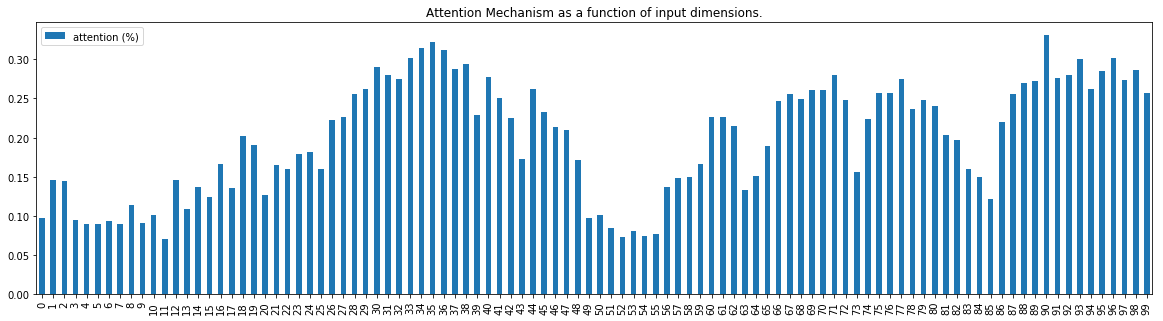

use(0) in(1) the(2) Midlife(3) in(4) the(5) United(6) States(7) ((8) MIDUS(9) )(10) study(11) ((12) Goodwin(13) &(14) Gotlib(15) ,(16) 2004(17) ).(18) The(19) NSHAP(20) team(21) further(22) modified(23) the(24) MIDI(25) to(26) shorten(27) it(28) further(29) ,(30) in(31) order(32) to(33) fit(34) it(35) into(36) an(37) already(38) lengthy(39) leave(40) -(41) behind(42) questionnaire(43) .(44) The(45) differences(46) between(47) the(48) MIDUS(49) MIDI(50) ,(51) Health(52) and(53) Retirement(54) Study(55) ((56) HRS(57) )(58) MIDI(59) ,(60) and(61) the(62) NSHAP(63) MIDI(64) battery(65) are(66) shown(67) in(68) Table(69) 1(70) .(71) In(72) NSHAP(73) W2(74) ,(75) 2(76) ,(77) 949(78) individuals(79) returned(80) the(81) leave(82) -(83) behind(84) questionnaire(85) ((86) 87(87) .(88) 3(89) %),(90) and(91) 2(92) ,(93) 848(94) individuals(95) filled(96) out(97) any(98) of(99)


<Figure size 720x5760 with 0 Axes>

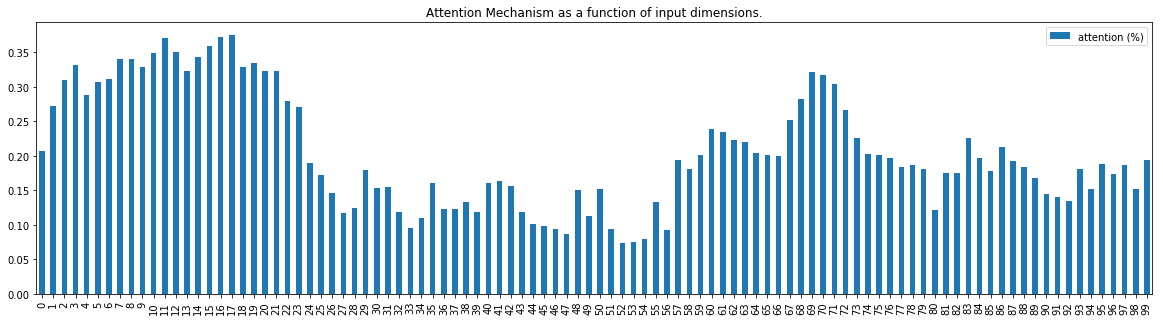

00952990(0) .(1) 2015(2) .(3) 1011745(4) Hashish(5) use(6) among(7) US(8) teens(9) 203(10) popularity(11) of(12) marijuana(13) use(14) and(15) increasing(16) rates(17) of(18) use(19) of(20) hashish(21) products(22) .(23) Acknowledgements(24) Monitoring(25) the(26) Future(27) data(28) were(29) collected(30) through(31) a(32) research(33) grant(34) ((35) R01(36) DA(37) -(38) 01411(39) )(40) from(41) the(42) National(43) Institute(44) on(45) Drug(46) Abuse(47) ((48) NIDA(49) ),(50) National(51) Institutes(52) of(53) Health(54) ((55) NIH(56) ).(57) The(58) content(59) is(60) solely(61) the(62) responsibility(63) of(64) the(65) authors(66) and(67) does(68) not(69) necessarily(70) represent(71) the(72) official(73) views(74) of(75) the(76) principal(77) investigators(78) ,(79) NIH(80) or(81) NIDA(82) .(83) The(84) authors(85) would(86) like(87) to(88) thank(89) the(90) principal(91) investigators(92) ((93) PIs(94) :(95) Johnston(96) ,(97) Bachman(98) ,(99)


<Figure size 720x5760 with 0 Axes>

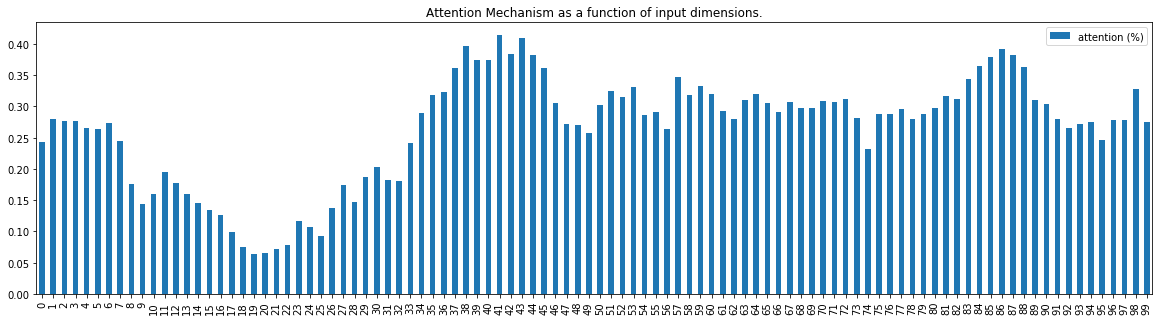

is(0) conditioned(1) by(2) the(3) MAOA(4) genotype(5) .(6) The(7) study(8) analyzes(9) data(10) from(11) the(12) U(13) .(14) S(15) .(16) National(17) Longitudinal(18) Study(19) of(20) Adolescent(21) Health(22) ((23) Add(24) Health(25) ),(26) a(27) nationally(28) representative(29) ,(30) genetically(31) informative(32) sample(33) .(34) We(35) find(36) evidence(37) that(38) meal(39) deprivation(40) increases(41) the(42) likelihood(43) of(44) both(45) verbal(46) deficits(47) and(48) psychopathic(49) personality(50) traits(51) ,(52) whereas(53) poor(54) quality(55) nutrition(56) increases(57) the(58) risk(59) of(60) verbal(61) deficits(62) .(63) We(64) detect(65) the(66) presence(67) of(68) a(69) number(70) of(71) gene(72) -(73) environment(74) interactions(75) between(76) measures(77) of(78) food(79) quality(80) and(81) MAOA(82) genotype(83) ,(84) but(85) no(86) evidence(87) of(88) GxE(89) in(90) the(91) case(92) of(93) meal(94) deprivation(95) .(96) Limitations(97) are(98) noted(99)


<Figure size 720x5760 with 0 Axes>

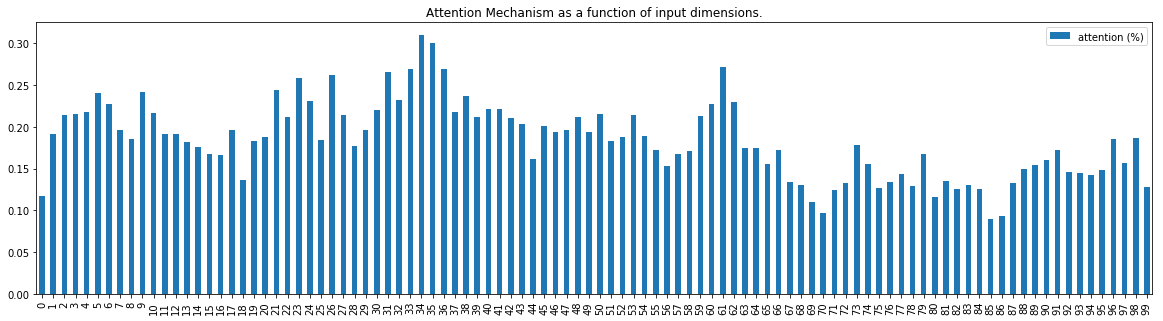

Submitted(0) 14(1) April(2) 2015(3) Accepted(4) 3(5) June(6) 2015(7) Published(8) 30(9) June(10) 2015(11) Corresponding(12) author(13) Kwon(14) Chan(15) Jeon(16) ,(17) kcjeon(18) @(19) email(20) .(21) tamu(22) .(23) edu(24) Academic(25) editor(26) Robert(27) Patton(28) Additional(29) Information(30) and(31) Declarations(32) can(33) be(34) found(35) on(36) page(37) 26(38) DOI(39) 10(40) .(41) 7717(42) /(43) peerj(44) .(45) 1052(46) Copyright(47) 2015(48) Jeon(49) and(50) Goodson(51) Distributed(52) under(53) Creative(54) Commons(55) CC(56) -(57) BY(58) 4(59) .(60) 0(61) OPEN(62) ACCESS(63) US(64) adolescents(65) '(66) friendship(67) networks(68) and(69) health(70) risk(71) behaviors(72) :(73) a(74) systematic(75) review(76) of(77) studies(78) using(79) social(80) network(81) analysis(82) and(83) Add(84) Health(85) data(86) Kwon(87) Chan(88) Jeon(89) and(90) Patricia(91) Goodson(92) Department(93) of(94) Health(95) &(96) Kinesiology(97) ,(98) Texas(99)


<Figure size 720x5760 with 0 Axes>

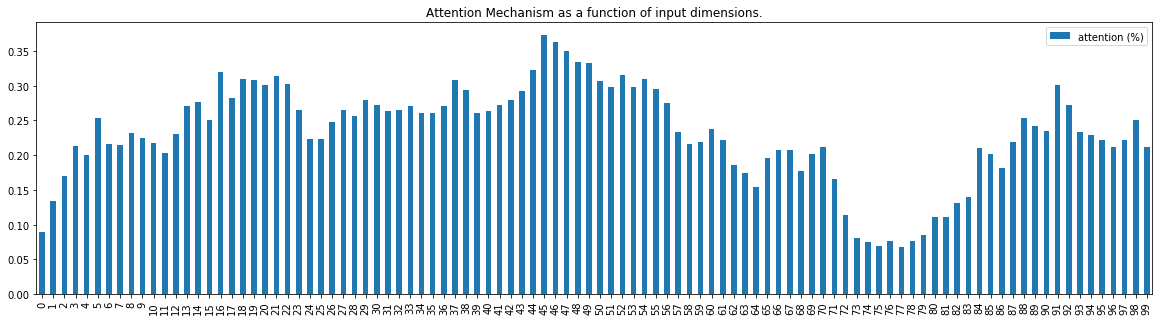

clakon(0) @(1) uci(2) .(3) edu(4) Abstract(5) Social(6) support(7) from(8) peers(9) and(10) parents(11) provides(12) a(13) key(14) socialization(15) function(16) during(17) adoles(18) -(19) cence(20) .(21) We(22) examine(23) adolescent(24) friendship(25) networks(26) using(27) a(28) Stochastic(29) Actor(30) -(31) Based(32) model(33) -(34) ing(35) approach(36) to(37) observe(38) the(39) flow(40) of(41) emotional(42) support(43) provision(44) to(45) peers(46) and(47) the(48) effect(49) of(50) support(51) from(52) parents(53) ,(54) while(55) simultaneously(56) modeling(57) smoking(58) behavior(59) .(60) We(61) utilized(62) one(63) school(64) ((65) n(66) =(67) 976(68) )(69) from(70) The(71) National(72) Longitudinal(73) Study(74) of(75) Adolescent(76) to(77) Adult(78) Health(79) ((80) AddHealth(81) )(82) Study(83) .(84) Our(85) findings(86) suggest(87) that(88) emotional(89) support(90) is(91) transacted(92) through(93) an(94) interdependent(95) contextual(96) system(97) ,(98) comprised(99

<Figure size 720x5760 with 0 Axes>

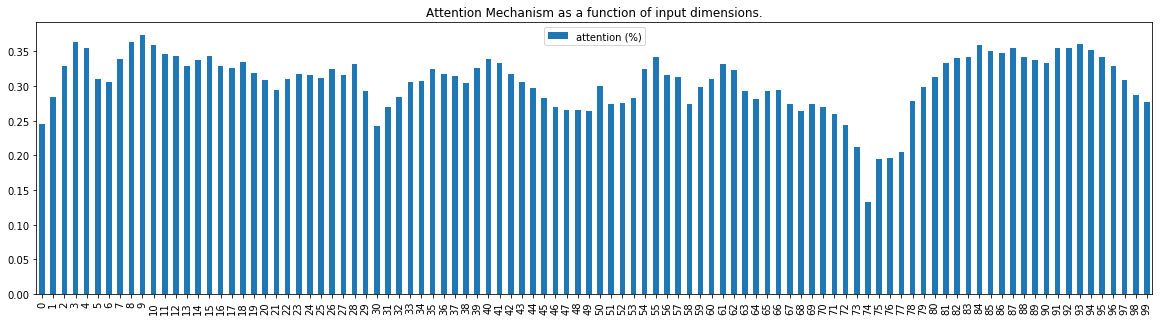

34(0) .(1) 16(2) 35(3) .(4) 09(5) IS(6) >(7) N(8) 33(9) .(10) 77(11) 33(12) .(13) 95(14) 35(15) .(16) 31(17) 35(18) .(19) 58(20) IS(21) >(22) N(23) ;(24) IS(25) >(26) M(27) Married(28) (%)(29) .(30) 31(31) .(32) 38(33) .(34) 35(35) .(36) 54(37) IS(38) >(39) N(40) .(41) 70(42) .(43) 59(44) .(45) 66(46) .(47) 74(48) IS(49) <(50) M(51) ;(52) M(53) <(54) N(55) Cohabiting(56) (%)(57) .(58) 15(59) .(60) 18(61) .(62) 09(63) .(64) 15(65) .(66) 09(67) .(68) 12(69) .(70) 13(71) .(72) 09(73) Education(74) ((75) yrs(76) )(77) 15(78) .(79) 81(80) 14(81) .(82) 88(83) 15(84) .(85) 31(86) 14(87) .(88) 21(89) IS(90) <(91) N(92) 13(93) .(94) 65(95) 13(96) .(97) 41(98) 13(99)


<Figure size 720x5760 with 0 Axes>

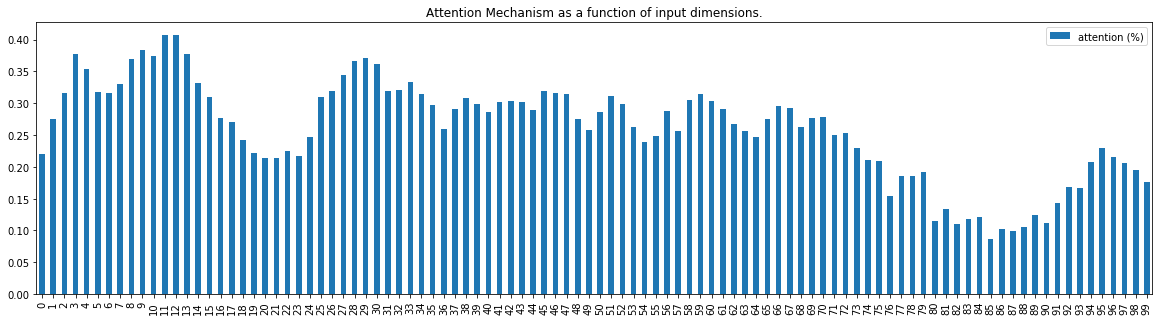

white(0) women(1) when(2) compared(3) with(4) black(5) women(6) ,(7) whereas(8) others(9) demonstrate(10) no(11) difference(12) in(13) the(14) percentage(15) of(16) the(17) IAAT(18) loss(19) among(20) the(21) two(22) races(23) ((24) 8(25) -(26) 11(27) ).(28) There(29) is(30) a(31) need(32) to(33) clarify(34) the(35) racial(36) specifics(37) of(38) the(39) naturalistic(40) long(41) -(42) term(43) IAAT(44) changes(45) among(46) mid(47) -(48) life(49) women(50) .(51) The(52) principal(53) focus(54) of(55) this(56) investigation(57) was(58) to(59) compare(60) the(61) natural(62) -(63) istic(64) long(65) -(66) term(67) IAAT(68) changes(69) among(70) black(71) and(72) white(73) women(74) during(75) midlife(76) .(77) Methods(78) The(79) Study(80) of(81) Women(82) '(83) s(84) Health(85) Across(86) the(87) Nation(88) ((89) SWAN(90) ),(91) a(92) community(93) -(94) based(95) seven(96) -(97) center(98) observational(99)


<Figure size 720x5760 with 0 Axes>

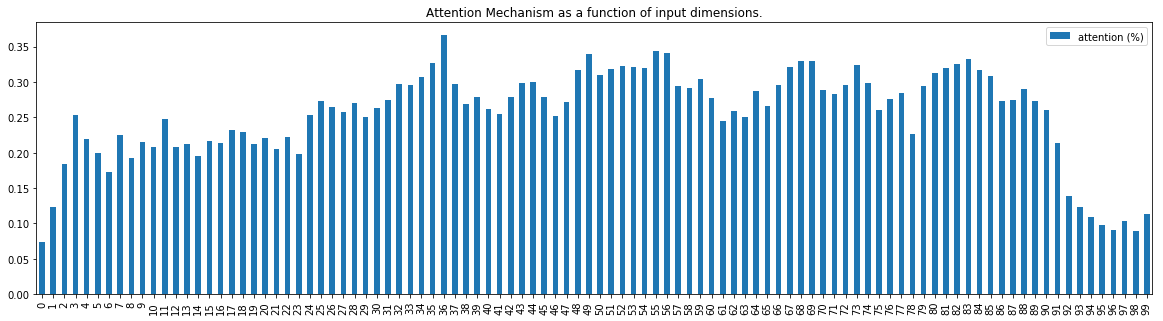

highlighted(0) thus(1) far(2) ((3) Dixit(4) and(5) Pindyck(6) ,(7) 1994(8) ,(9) Hassler(10) ,(11) 1996(12) and(13) 2001(14) ,(15) and(16) ,(17) more(18) recently(19) ,(20) Bloom(21) ,(22) 2009(23) ).(24) We(25) find(26) the(27) wait(28) -(29) and(30) -(31) see(32) -(33) effect(34) to(35) be(36) dominated(37) by(38) the(39) bad(40) news(41) effect(42) .(43) In(44) the(45) aforementioned(46) model(47) context(48) ,(49) cyclical(50) changes(51) in(52) uncertainty(53) correspond(54) naturally(55) to(56) cyclical(57) changes(58) in(59) the(60) cross(61) -(62) section(63) of(64) firms(65) ­(66) more(67) specifically(68) the(69) dispersions(70) of(71) change(72) rates(73) of(74) firm(75) -(76) level(77) Solow(78) residuals(79) ,(80) real(81) value(82) added(83) and(84) real(85) sales(86) .(87) Thus(88) ,(89) using(90) the(91) balance(92) sheet(93) data(94) set(95) of(96) Deutsche(97) Bundesbank(98) ((99)


<Figure size 720x5760 with 0 Axes>

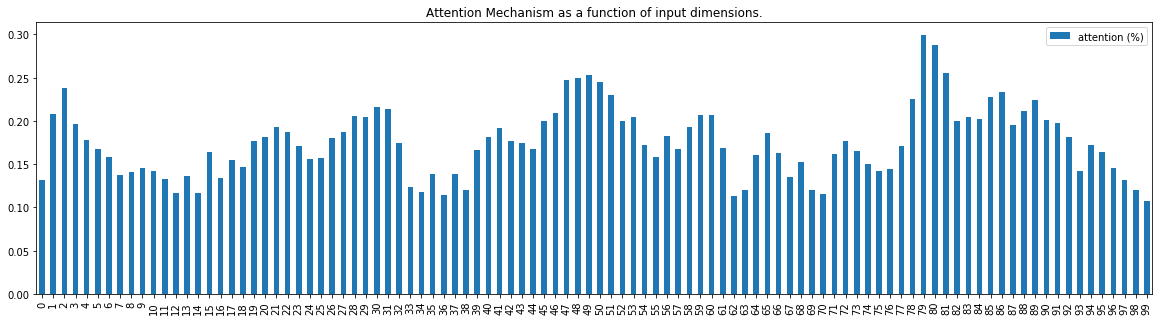

;(0) derived(1) from(2) a(3) database(4) of(5) the(6) Deutsche(7) Bundesbank(8) containing(9) the(10) German(11) FDI(12) stock(13) statistics(14) ),(15) §(16) the(17) investment(18) target(19) '(20) s(21) return(22) on(23) assets(24) in(25) %(26) ((27) RETURN(28) ;(29) derived(30) from(31) the(32) FDI(33) database(34) ),(35) §(36) the(37) investment(38) target(39) '(40) s(41) equity(42) capitalization(43) in(44) %(45) ((46) CAPRATIO(47) ;(48) paid(49) -(50) in(51) equity(52) capital51(53) divided(54) by(55) total(56) assets(57) ;(58) derived(59) from(60) the(61) FDI(62) database(63) ).(64) 48(65) Interviews(66) conducted(67) with(68) banking(69) projects(70) officers(71) at(72) the(73) IFC(74) in(75) Washington(76) D(77) .(78) C(79) .(80) on(81) April(82) 17(83) and(84) 22(85) ,(86) 2003(87) .(88) No(89) such(90) interview(91) was(92) solicited(93) from(94) the(95) other(96) multilateral(97) agency(98) included(99)


<Figure size 720x5760 with 0 Axes>

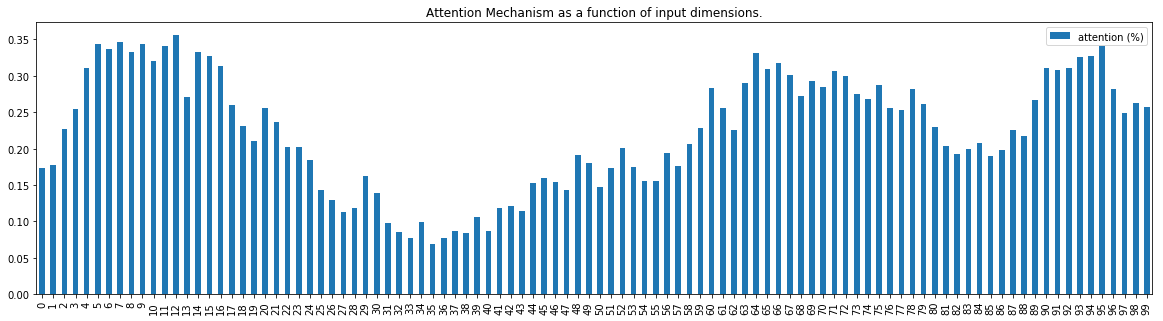

The(0) Howard(1) journal(2) Vol(3) 24(4) No(5) 3(6) .(7) Aug(8) 85(9) ISSN(10) 0265(11) -(12) 5527(13) 12(14) .(15) 50(16) Dealing(17) with(18) Offenders(19) :(20) Popular(21) Opinion(22) and(23) the(24) Views(25) of(26) Victims(27) Findings(28) from(29) the(30) British(31) Crime(32) Survey(33) MIKE(34) HOUGH(35) and(36) DAVID(37) MOXON(38) Mike(39) Hough(40) is(41) Principal(42) Research(43) Officer(44) and(45) David(46) Moxon(47) is(48) Senior(49) Research(50) Officer(51) ,(52) Home(53) Office(54) Research(55) and(56) Planning(57) Unit(58) Abstract(59) :(60) Increasing(61) emphasis(62) is(63) being(64) placed(65) both(66) on(67) achieving(68) a(69) better(70) fit(71) between(72) sentencing(73) policy(74) and(75) public(76) opinion(77) and(78) on(79) meeting(80) the(81) needs(82) and(83) wishes(84) of(85) victims(86) of(87) crime(88) .(89) There(90) has(91) ,(92) however(93) ,(94) been(95) a(96) dearth(97) of(98) factual(99)


<Figure size 720x5760 with 0 Axes>

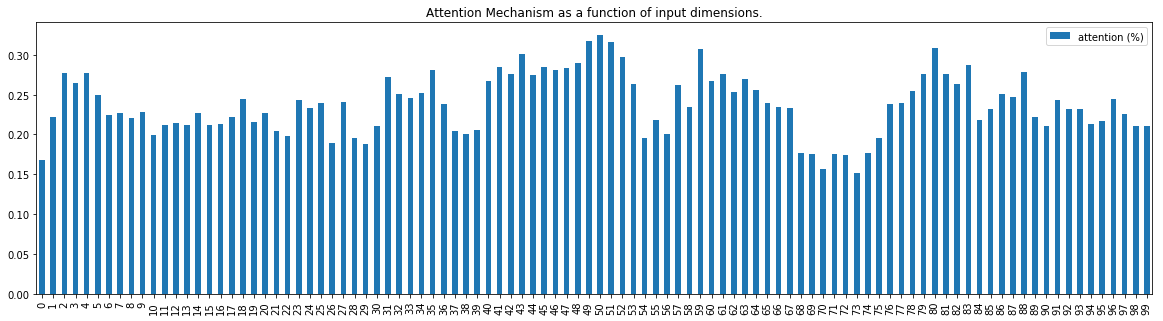

sex(0) ,(1) length(2) of(3) stay(4) ,(5) and(6) cen(7) -(8) sus(9) geographic(10) region(11) ((12) Northeast(13) ,(14) Mid(15) -(16) west(17) ,(18) South(19) ,(20) and(21) West(22) ).(23) 26(24) Because(25) data(26) on(27) race(28) /(29) ethnicity(30) were(31) missing(32) from(33) 23(34) %(35) of(36) discharge(37) records(38) examined(39) ,(40) we(41) made(42) no(43) comparisons(44) by(45) ethnici(46) -(47) ty(48) .(49) 21(50) ,(51) 27(52) Temporal(53) trends(54) in(55) hospitaliza(56) -(57) tions(58) were(59) examined(60) by(61) discharge(62) month(63) and(64) year(65) .(66) From(67) 1988(68) through(69) 1996(70) ,(71) aggregate(72) estimates(73) of(74) dis(75) -(76) charges(77) by(78) month(79) were(80) made(81) using(82) only(83) records(84) sampled(85) from(86) hospitals(87) fully(88) re(89) -(90) sponding(91) for(92) that(93) year(94) ((95) I(96) .(97) M(98) .(99)


<Figure size 720x5760 with 0 Axes>

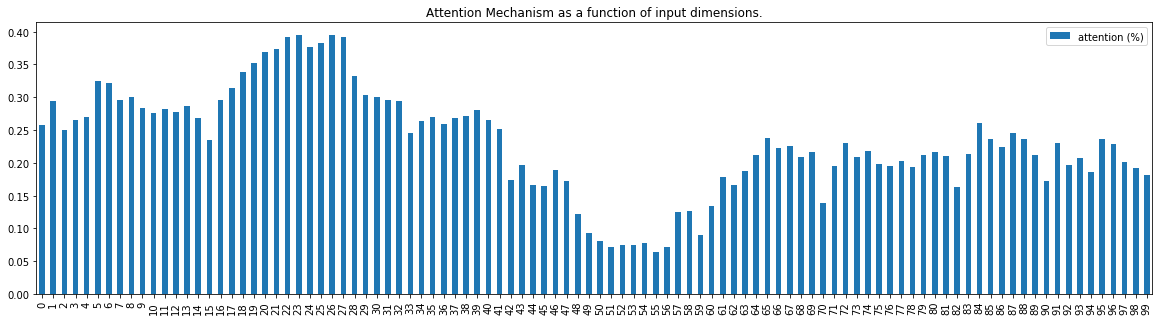

of(0) the(1) epide(2) -(3) miologicaldataassociatingrelativelylow(4) levels(5) of(6) lead(7) in(8) the(9) blood(10) with(11) cardio(12) -(13) vascular(14) outcomes1(15) ,(16) 2(17) ,(18) 4(19) ,(20) 19(21) -(22) 38(23) and(24) because(25) hypertension(26) is(27) a(28) significant(29) health(30) con(31) -(32) cern(33) for(34) women(35) after(36) menopause(37) .(38) 39(39) METHODS(40) The(41) study(42) population(43) included(44) women(45) from(46) the(47) Third(48) National(49) Health(50) and(51) Nu(52) -(53) trition(54) Examination(55) Survey(56) ((57) NHANES(58) III(59) ),(60) a(61) cross(62) -(63) sectional(64) sample(65) obtained(66) through(67) a(68) complex(69) survey(70) design(71) ,(72) rep(73) -(74) resenting(75) the(76) US(77) civilian(78) ,(79) noninstitu(80) -(81) tionalized(82) population(83) .(84) During(85) a(86) 6(87) -(88) year(89) period(90) ((91) 1988(92) -(93) 1994(94) ),(95) participants(96) took(97) part(98) in(99)


In [20]:
##plot for every 50th sentence in test set
for i in range(len(X_test)//50):
    get_activations(model, np.array([X_test[i*50]]),i*50, print_shape_only=True, layer_name='time_distributed_1')